In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.units
from astropy import constants as const
import collections, numpy
import matplotlib.lines as mlines
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                             AutoMinorLocator)
from scipy.stats import linregress
import sys
import math as ma
from numpy import inf
import numpy as np
import time
from matplotlib.pyplot import figure as fig
from scipy import stats
from scipy.stats import norm



In [3]:
#Defining Variables and constants

Big_M = (1e8 * const.M_sun.value) #kg
Obj_Radius = 0.1 * const.au.value # m
Small_M = const.M_sun.value
vi = 2e9 #m/s
xi = 4*const.au.value
ymax = const.au.value  #m
#ypos=np.linspace(0,1,int(N)+1)[1:]*(ymax)


    
dt = 10 # second time step
N = 50 #Number of steps 


colors = mpl.cm.get_cmap()(np.linspace(0.0, 1.0, int(N))) # setting colors for data pts


escape_vel= np.sqrt(2*const.G.value * Big_M/xi)
print(f"escape velocity = {escape_vel/1e5:.4e}")
escape_time = xi/(escape_vel * vi)
#print(f"escape time = {time:.4e}")
dt,ymax

escape velocity = 2.1061e+03


(10, 149597870700.0)

In [4]:
ymax

149597870700.0

In [5]:
#defining my motion functions in order to place inside leapfrog function for loop
def Position(x,vx,ax,dt):
    x = x + vx * dt + 0.5*(ax)*dt**2
    return x

def Acceleration(xpos,ypos):
    a = ((-const.G.value*Big_M/((xpos**2+ypos**2)**(3/2))))
    return a

def Velocity(vx,ax,ax_1,dt):
    vx = vx + 0.5*(ax + ax_1)*dt
    return vx
    

In [6]:
#Leapfrog for 10 particle DUPLICATE not using second for loop and using a functio for the entire calculation. 
def leapfrog(xi,ymax,vi,N,P,dt):

    x = np.ones(P)*xi
    y = np.linspace(0,1,int(P)+1)[1:]*(ymax)
    vx = np.ones(P)*(-vi)
    vy = np.zeros(P)


    Xpos=np.zeros((P,N))
    Ypos=np.zeros((P,N))
    Xvel=np.zeros((P,N))
    Yvel=np.zeros((P,N))
    Xacc=np.zeros((P,N))
    Yacc=np.zeros((P,N))

    Xpos[:,0]=x
    Ypos[:,0]=y
    Xvel[:,0]=vx
    Yvel[:,0]=vy
    Xacc[:,0]=((-const.G.value*Big_M/((Xpos[:,0]**2+Ypos[:,0]**2)**(3/2)))*Xpos[:,0])
    Yacc[:,0]=((-const.G.value*Big_M/((Xpos[:,0]**2+Ypos[:,0]**2)**(3/2)))*Ypos[:,0])
    for i in range(N-1):
        #for j in range(p):

        Xpos[:,i+1] = Position(Xpos[:,i],Xvel[:,i],Xacc[:,i],dt)
            #Xpos[j,i+1] = Xpos[j,i] + Xvel[j,i] *dt + 0.5*(Xacc[j,i])*dt**2 
        Ypos[:,i+1] = Position(Ypos[:,i],Yvel[:,i],Yacc[:,i],dt) 

            #print(Xpos) #The x pos at this point is giving iterating up to N=1

        Acc=Acceleration(Xpos[:,i+1],Ypos[:,i+1]) 
        Xacc[:,i+1] = Acc*Xpos[:,i+1]
        Yacc[:,i+1] = Acc*Ypos[:,i+1]

        Xvel[:,i+1] = Velocity(Xvel[:,i],Xacc[:,i],Xacc[:,i+1],dt)
        Yvel[:,i+1] = Velocity(Yvel[:,i],Yacc[:,i],Yacc[:,i+1],dt)
            #we can do vels for every particle at one time
        
    return Xpos, Ypos, Xvel, Yvel, Xacc, Yacc
    


In [7]:
#defining velocity and position functions that will be used in the euler function below
def vel(vx,x_acc,dt):
    vx=vx+x_acc*dt
    return vx

def pos(x,vx,dt):
    x=x+vx*dt
    return x


#Rewriting Euler integration in a function format and using array operations in one for loop

def euler(xi,ymax,vi,N,P,dt):
    vy = np.zeros(P)
    vx = np.ones(P)*(-vi)
    y=np.linspace(0,1,int(P)+1)[1:]*(ymax)
    x = np.ones(P)*xi

    Time_e = np.zeros((P,N))     
    Xpos_e = np.zeros((P,N))
    Ypos_e = np.zeros((P,N))
    Yvel_e = np.zeros((P,N))
    Xvel_e = np.zeros((P,N))
    Xacc_e=np.zeros((P,N))
    Yacc_e=np.zeros((P,N))

    Xpos_e[:,0]=x
    Ypos_e[:,0]=y
    Xvel_e[:,0]=vx
    Yvel_e[:,0]=vy
    Xacc_e[:,0]=((-const.G.value*Big_M/((Xpos_e[:,0]**2+Ypos_e[:,0]**2)**(3/2)))*Xpos_e[:,0])
    Yacc_e[:,0]=((-const.G.value*Big_M/((Xpos_e[:,0]**2+Ypos_e[:,0]**2)**(3/2)))*Ypos_e[:,0])

    for i in range(N-1): #Avoid square arrays!!!
        #print("i=", i)
        Xacc_e[:,i+1] = Acceleration(Xpos_e[:,i],Ypos_e[:,i])*Xpos_e[:,i]
        Yacc_e[:,i+1] = Acceleration(Xpos_e[:,i],Ypos_e[:,i])*Ypos_e[:,i]
        Xvel_e[:,i+1] = vel(Xvel_e[:,i],Xacc_e[:,i],dt)
        Yvel_e[:,i+1] = vel(Yvel_e[:,i],Yacc_e[:,i],dt)
        Xpos_e[:,i+1] = pos(Xpos_e[:,i],Xvel_e[:,i],dt)
        Ypos_e[:,i+1] = pos(Ypos_e[:,i],Yvel_e[:,i],dt)

    return Xpos_e,Ypos_e,Xvel_e,Yvel_e,Xacc_e,Yacc_e


In [8]:
Xpos, Ypos, Xvel, Yvel, Xacc, Yacc = leapfrog(xi,ymax,vi,3000,2,5)
Xpos_e,Ypos_e,Xvel_e,Yvel_e,Xacc_e,Yacc_e = euler(xi,ymax,vi,3000,2,5)


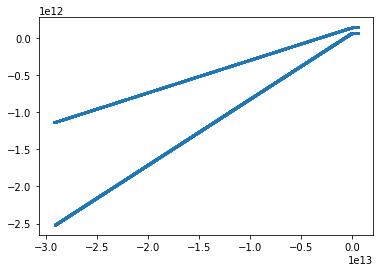

In [9]:
plt.scatter(Xpos, Ypos,s=3)

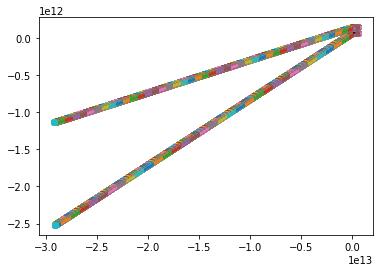

In [9]:
coeff = np.polyfit(Xpos[0][28:49],Ypos[0][28:49],1)
poly1d_fn = np.poly1d(coeff) 
# poly1d_fn is now a function which takes in x and returns an estimate for y

plt.plot(Xpos,Ypos, 'o', Xpos[0][28:49], poly1d_fn(Xpos[0][28:49]), '--k');
#plt.xlim(0, 5)
#plt.ylim(0, 12)

In [10]:
poly1d_fn, coeff

(poly1d([2.35525381e-03, 7.40295439e+10]),
 array([2.35525381e-03, 7.40295439e+10]))

slope of line 1: 0.0023552538087235567
slope of line 2: 0
angle of deflection: 0.13494585339753978


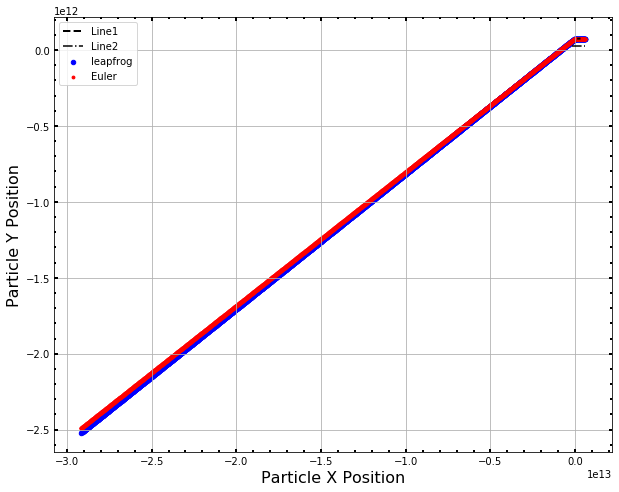

In [11]:
fig, ax = plt.subplots(figsize=[10,8])
ax.scatter(Xpos[0],Ypos[0],color='blue',s=20,label='leapfrog')
ax.plot(Xpos[0][28:49], poly1d_fn(Xpos[0][28:49]), '--k',lw=2,label='Line1')
ax.plot(np.linspace(-2e11,6e11,30),np.ones((30))*0.24e11,'-.k',label='Line2')
ax.scatter(Xpos_e[0],Ypos_e[0],color='red',s=8,label='Euler')
ax.set_xlabel('Particle X Position',fontsize=16)
ax.set_ylabel('Particle Y Position',fontsize=16)
ax.tick_params(which='both', direction='in',width=2)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.grid(True)
ax.legend()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator());
print('slope of line 1:',coeff[0])
print('slope of line 2:',0)
tan0=((coeff[0]-0)/(1+coeff[0]*0))
theta=ma.degrees(ma.atan(tan0))
print('angle of deflection:',theta)


In [278]:
Xpos, Ypos, Xvel, Yvel, Xacc, Yacc = leapfrog(xi,ymax,vi,500,6,5)
Xpos_e,Ypos_e,Xvel_e,Yvel_e,Xacc_e,Yacc_e = euler(xi,ymax,vi,500,6,5)


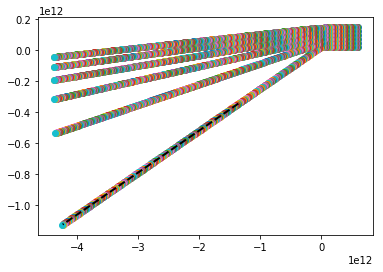

In [281]:
coef = np.polyfit(Xpos[0][199:499],Ypos[0][199:499],1)
poly1d_fn1 = np.poly1d(coef) 
# poly1d_fn is now a function which takes in x and returns an estimate for y

plt.plot(Xpos,Ypos, 'o', Xpos[0][199:499], poly1d_fn1(Xpos[0][199:499]), '--k',lw=2);
#plt.xlim(0, 5)
#plt.ylim(0, 12)

slope of line 1: 0.2534910085503651
slope of line 2: 0
angle of deflection: 14.224342455030902


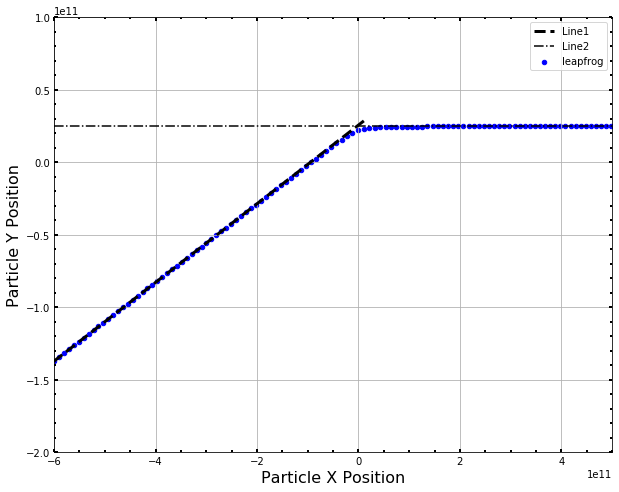

In [24]:
fig, ax = plt.subplots(figsize=[10,8])
ax.scatter(Xpos[0],Ypos[0],color='blue',s=20,label='leapfrog')
ax.plot(Xpos[0][58:499], poly1d_fn1(Xpos[0][58:499]), '--k',lw=3,label='Line1')
ax.plot(np.linspace(-6e11,6e11,30),np.ones((30))*0.25e11,'-.k',label='Line2')
#ax.scatter(Xpos_e[0],Ypos_e[0],color='red',s=8,label='Euler')
ax.set_xlabel('Particle X Position',fontsize=16)
ax.set_ylabel('Particle Y Position',fontsize=16)
ax.tick_params(which='both', direction='in',width=2)
ax.yaxis.set_ticks_position('both')
ax.legend()
ax.xaxis.set_ticks_position('both')
plt.xlim(-0.6e12,0.5e12)
plt.ylim(-0.2e12,0.1e12)
plt.grid(True)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator());
print('slope of line 1:',coeff[0])
print('slope of line 2:',0)
tan1=((coeff[0]-0)/(1+coeff[0]*0))
theta1=ma.degrees(ma.atan(tan1))
print('angle of deflection:',theta1)


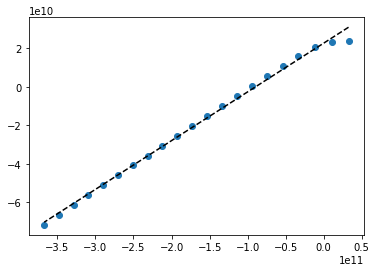

In [15]:
coeff = np.polyfit(Xpos[0][28:49],Ypos[0][28:49],1)
poly1d_fn = np.poly1d(coeff) 
# poly1d_fn is now a function which takes in x and returns an estimate for y

plt.plot(Xpos[0][28:49],Ypos[0][28:49], 'o', Xpos[0][28:49], poly1d_fn(Xpos[0][28:49]), '--k')
#plt.xlim(0, 5)
#plt.ylim(0, 12)

In [14]:
Xpos, Ypos, Xvel, Yvel, Xacc, Yacc = leapfrog(xi,ymax,vi,80,3,7)

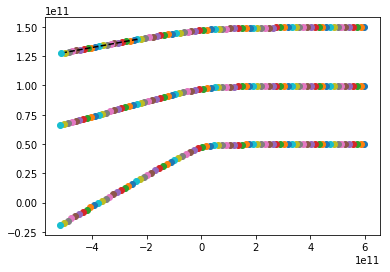

In [15]:
coeff = np.polyfit(Xpos[2][59:79], Ypos[2][59:79],1)
poly1d_fn = np.poly1d(coeff) 
# poly1d_fn is now a function which takes in x and returns an estimate for y

plt.plot(Xpos, Ypos, 'o', Xpos[2][59:79], poly1d_fn(Xpos[2][59:79]), '--k');
#plt.xlim(0, 5)
#plt.ylim(0, 12)

In [11]:
def fit(xpos, ypos):
    coef = np.polyfit(xpos,ypos,1)
    poly1d_fn = np.poly1d(coef) 
    angle = ma.degrees(ma.atan(((coef[0]-0)/(1+coef[0]*0))))
    return coef, poly1d_fn, angle

In [12]:
fit(Xpos[0][40:99], Ypos[0][40:99])

(array([6.26640612e-02, 6.87089352e+10]),
 poly1d([6.26640612e-02, 6.87089352e+10]),
 3.5856977195566975)

In [13]:
def Psi0(ymax, vi):
    psi0 = ma.atan(((ymax)*vi**2)/(const.G.value*(Big_M+Small_M)))
    return psi0
def theta(psi_0):
    the = ma.degrees(2*psi_0 - np.pi)
    return the

/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


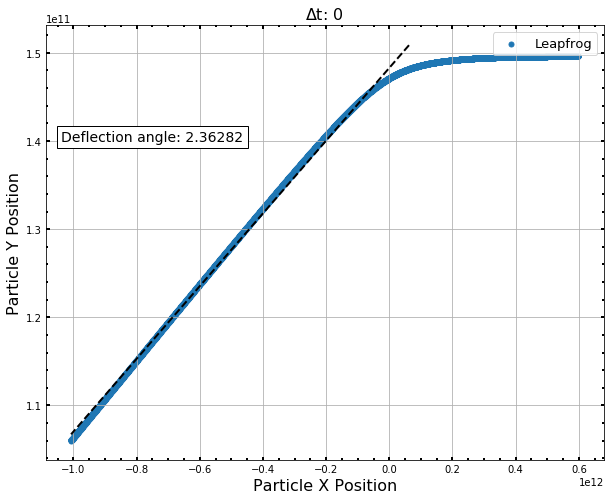

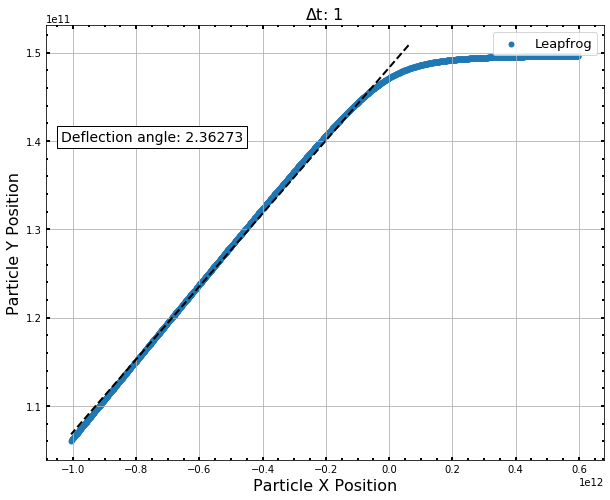

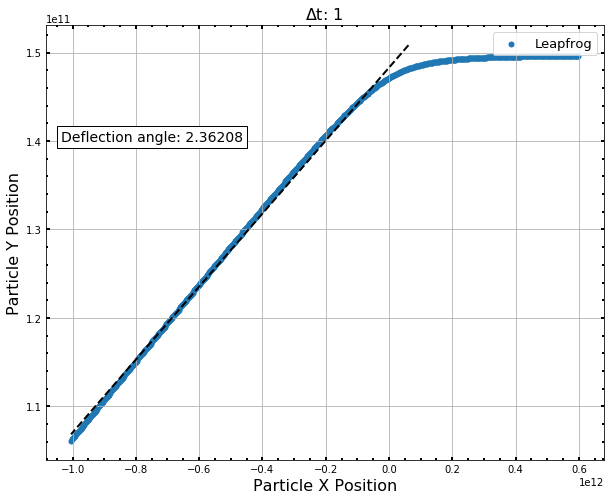

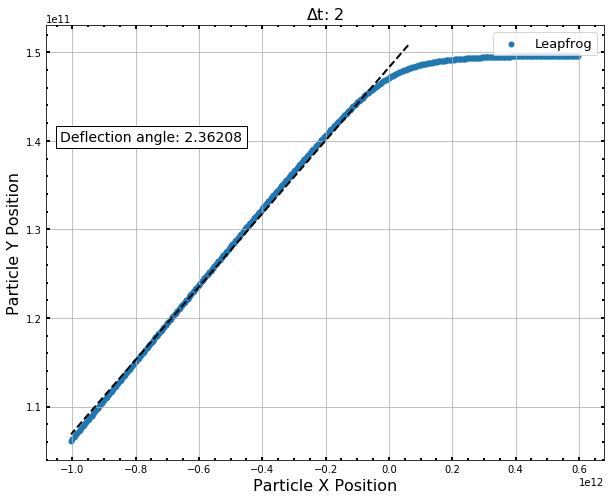

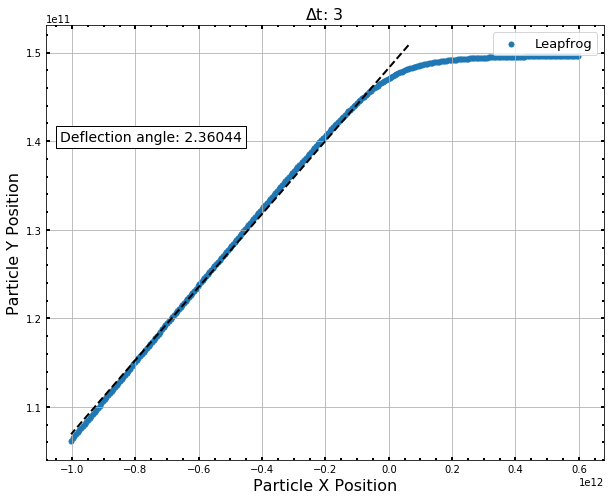

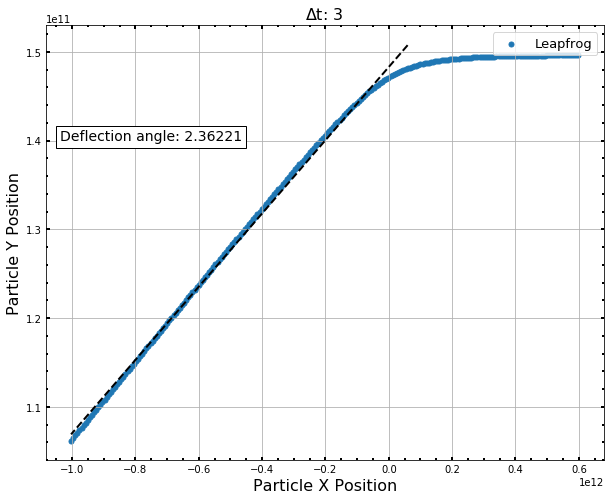

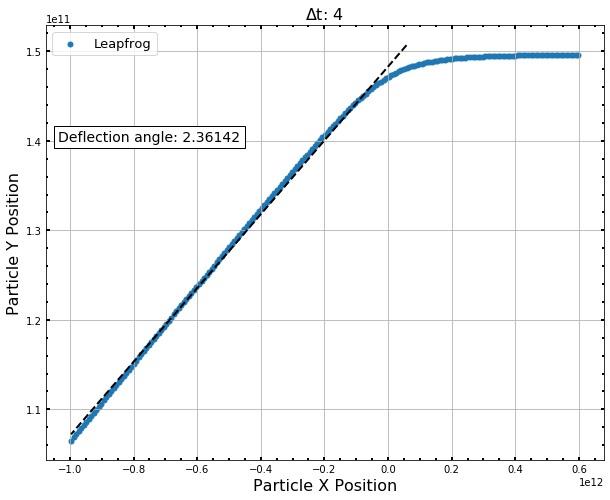

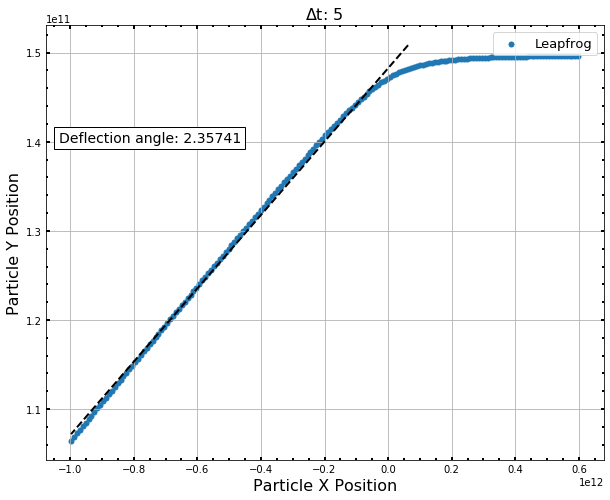

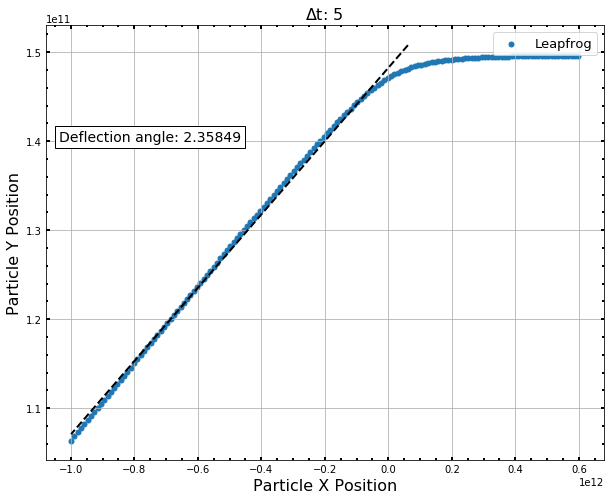

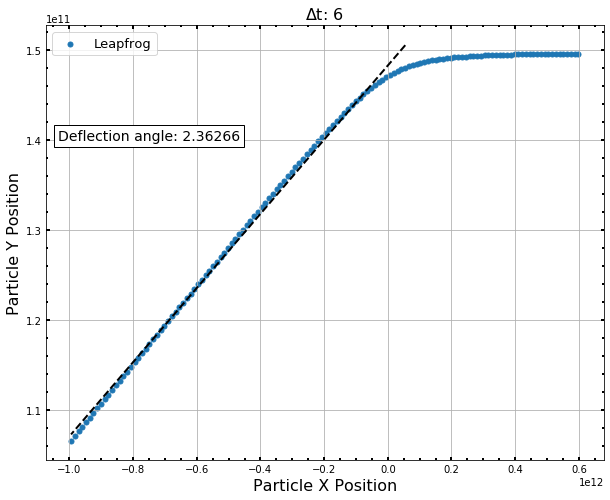

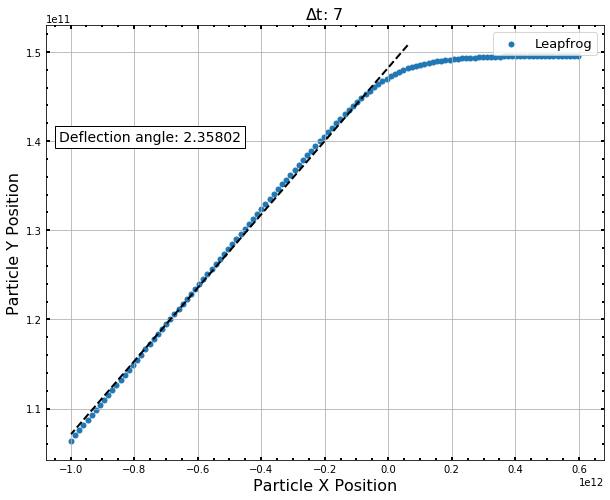

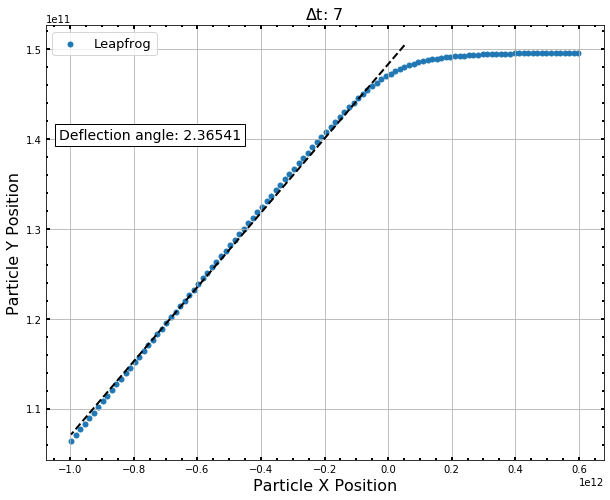

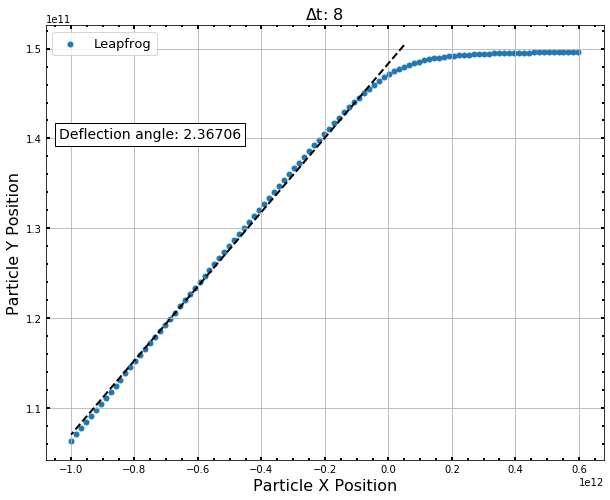

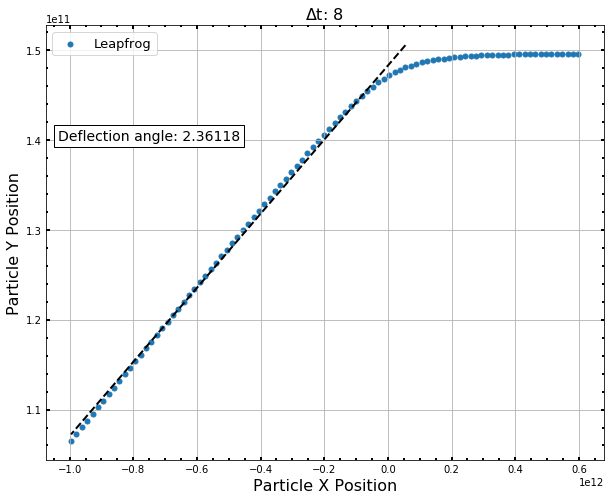

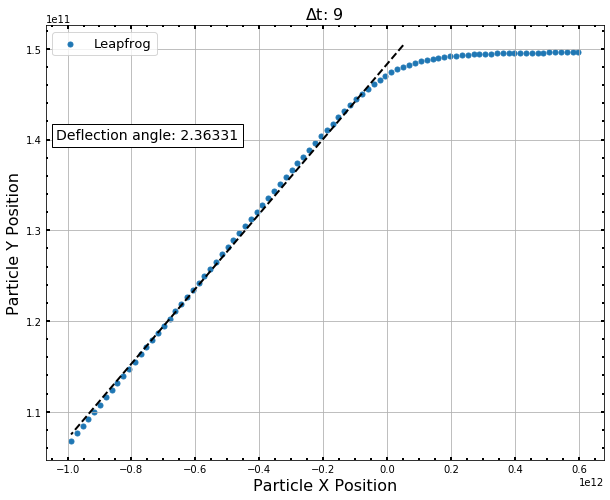

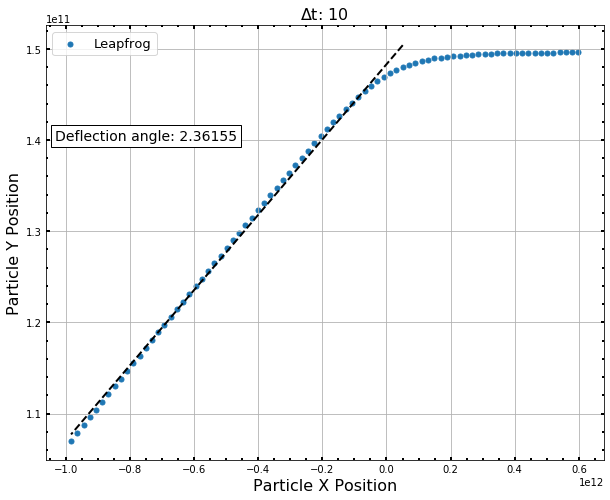

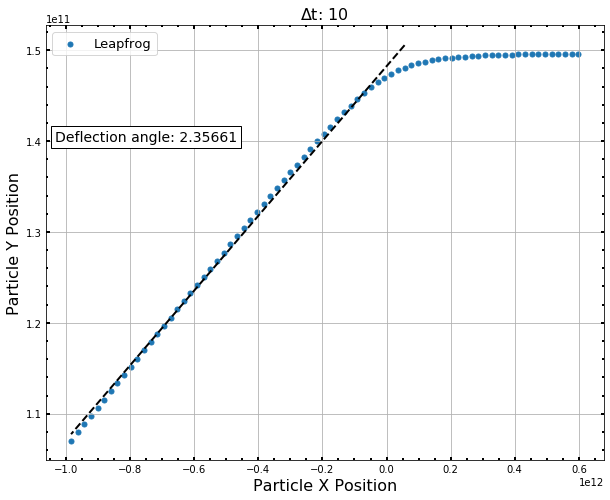

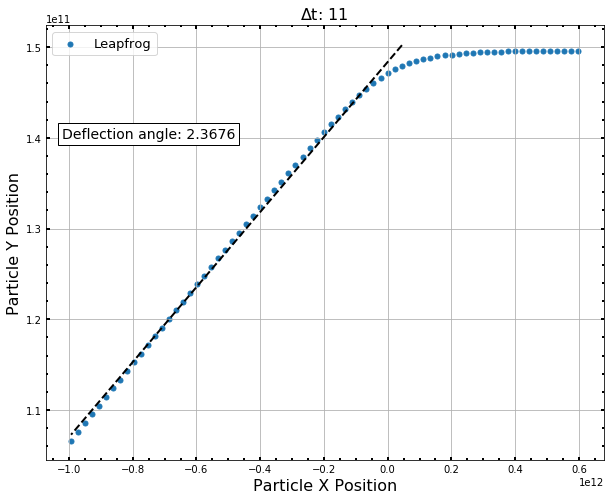

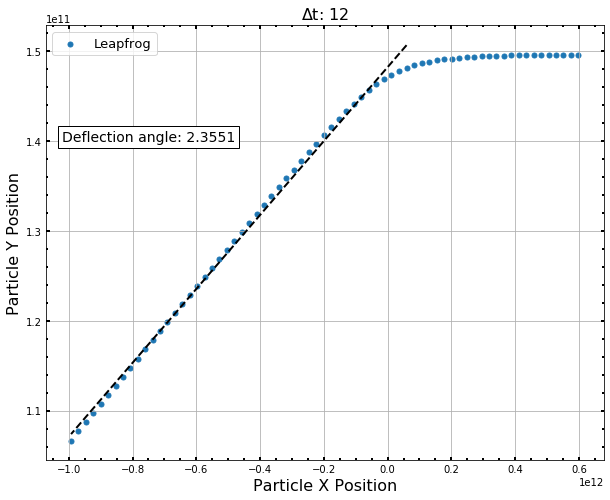

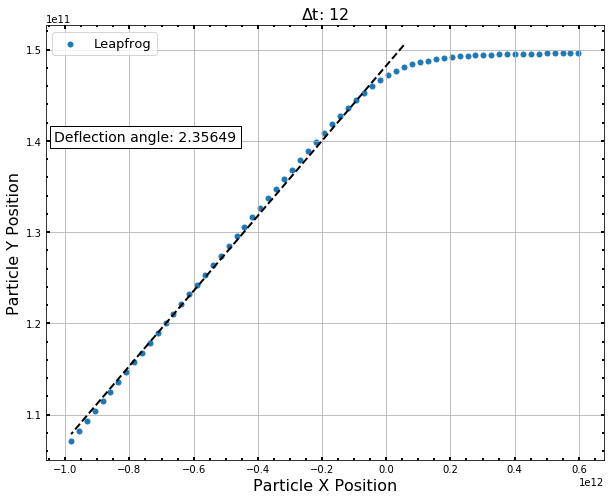

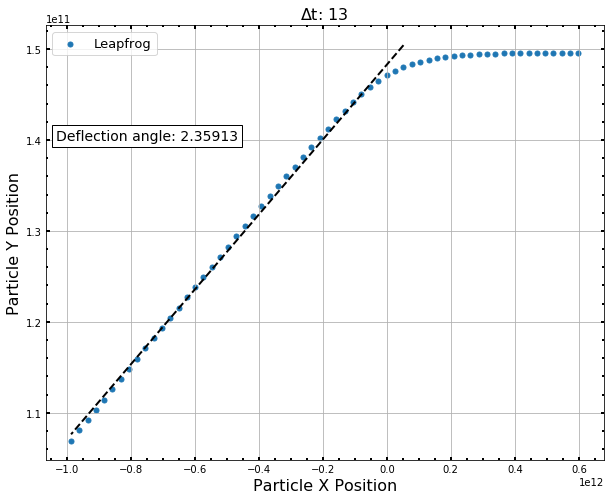

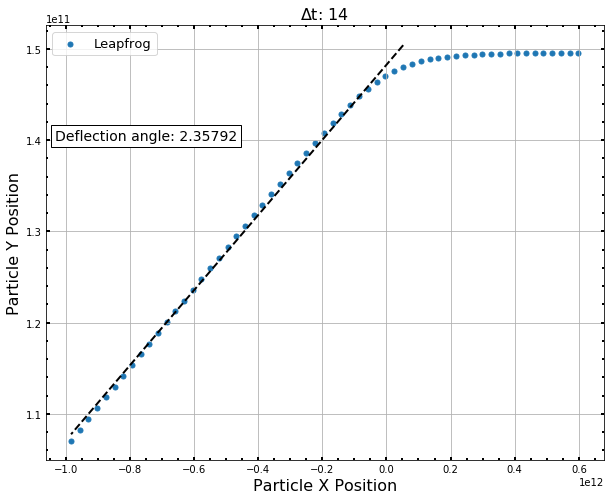

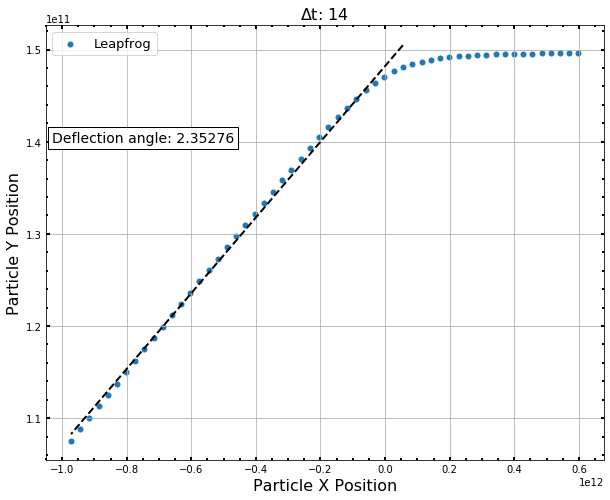

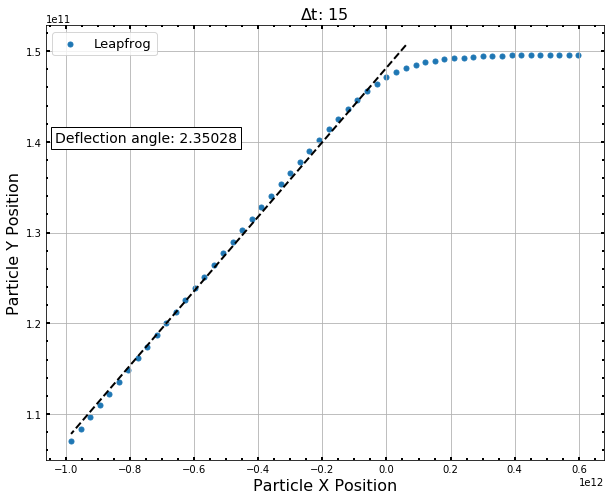

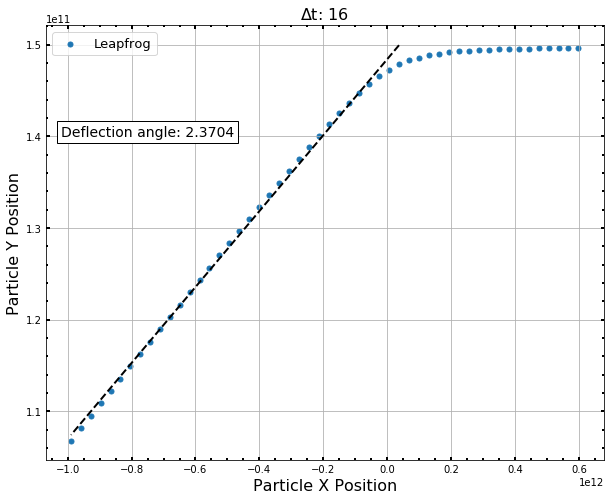

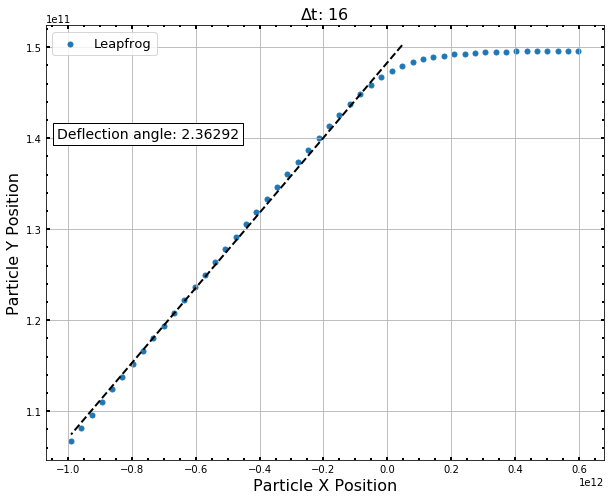

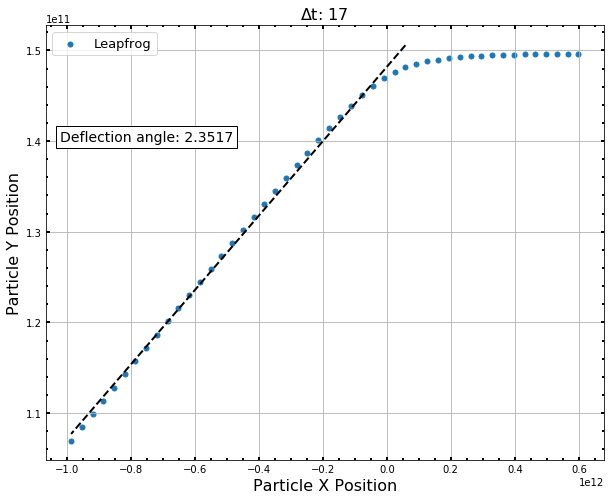

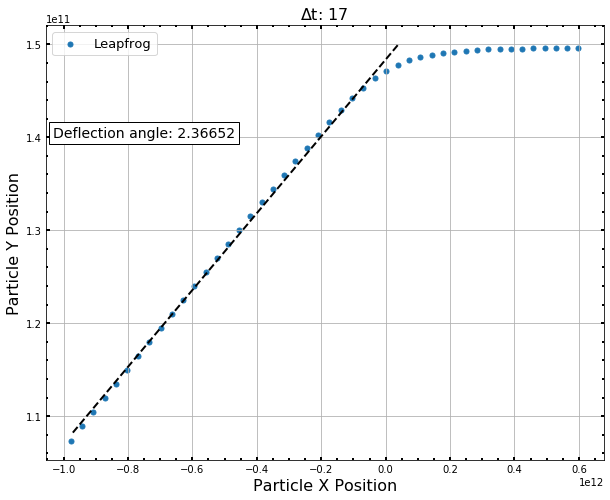

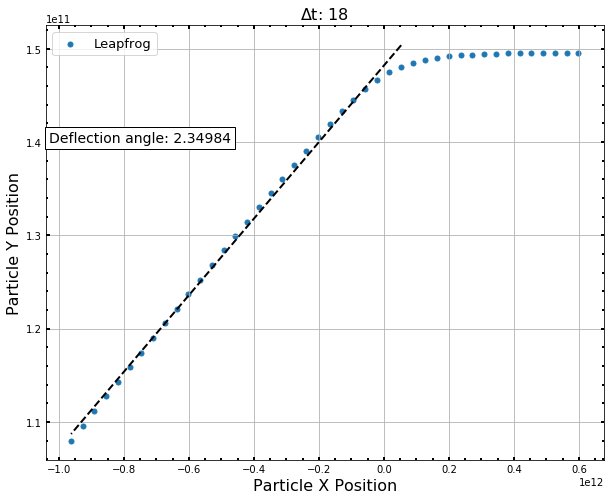

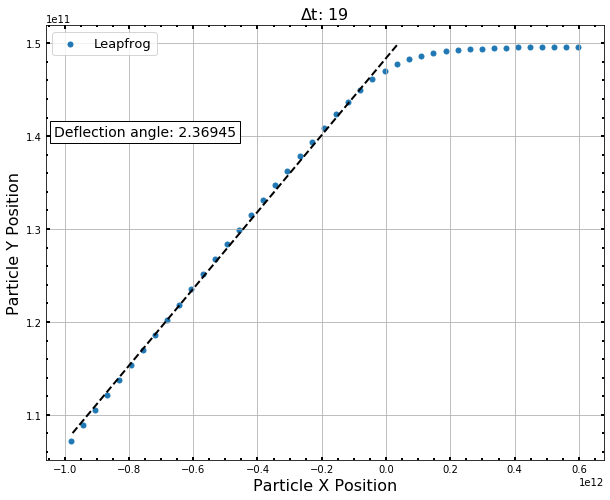

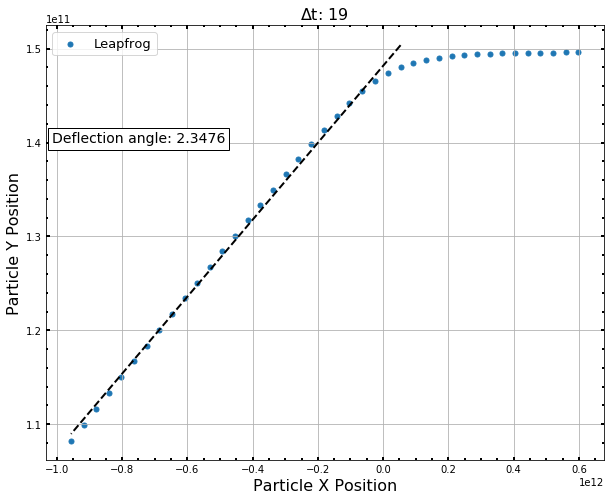

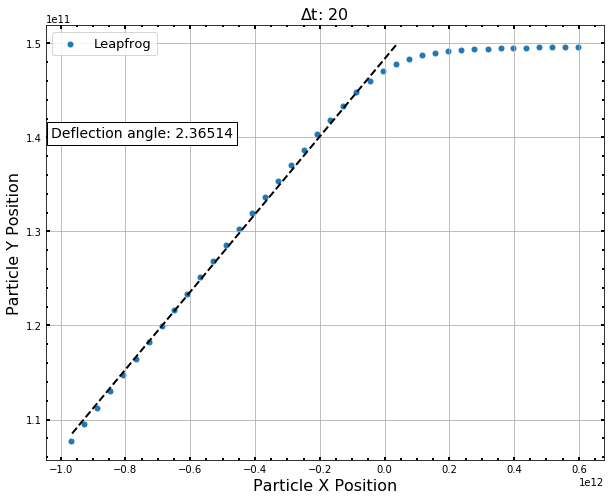

In [15]:
dts=np.linspace(0.1,20,32)
#dts=np.logspace(0.1,100,10)
time=800 #variable for how long the simulation will run for 

for i in range(len(dts)): 
    Nsteps=time/dts[i]
    Nsteps=int(np.round(Nsteps))
    xpos,ypos,xvel,yvel,xacc,yacc=leapfrog(xi,ymax,vi,Nsteps,1,dts[i])
    xpos_e,ypos_e,xvel_e,yvel_e,xacc_e,yacc_e=euler(xi,ymax,vi,Nsteps,1,dts[i])
    #print(xpos)
    cut = int(Nsteps/1.5)
    
    
    coef, poly1d_fn, angle = fit(xpos[0][-cut:],ypos[0][-cut:])
       
    
    fig, ax = plt.subplots(figsize=[10,8])
    ax.scatter(xpos[0],ypos[0],s=25,label='Leapfrog')
    ax.plot(xpos[0][-cut:], poly1d_fn(xpos[0][-cut:]), '--k',lw=2)
    ax.legend(fontsize=13)
    ax.set_title('$\Delta$t: {:d}'.
             format(int(np.round(dts[i]))),fontsize=16)
    ax.set_xlabel('Particle X Position',fontsize=16)
    ax.set_ylabel('Particle Y Position',fontsize=16)
    ax.tick_params(which='both', direction='in',width=2)
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    plt.grid(True)
    #plt.text(-0.95e12,1.3e11, '$\Delta$t: {:d}'.
     #        format(int(np.round(angle[i]))),horizontalalignment='center',bbox={'facecolor':'w'},fontsize=14)
    plt.text(-0.75e12,1.4e11, 'Deflection angle: {:g}'.
             format(angle),horizontalalignment='center',bbox={'facecolor':'w'},fontsize=14)
    
    #print('dt,slope, intercept, Angle:',int(np.round(dts[i])),coef, angle)
    

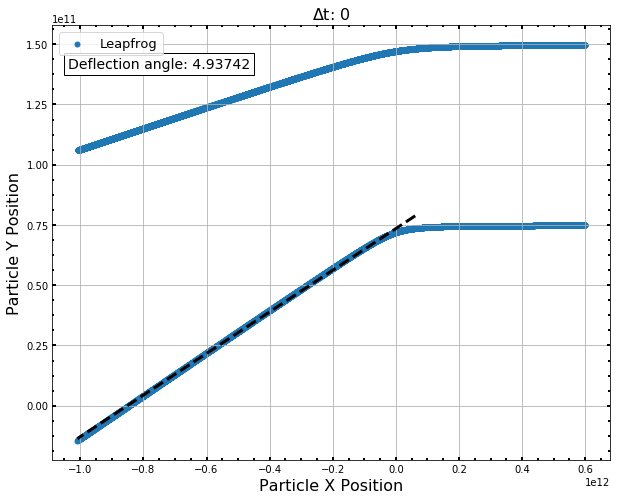

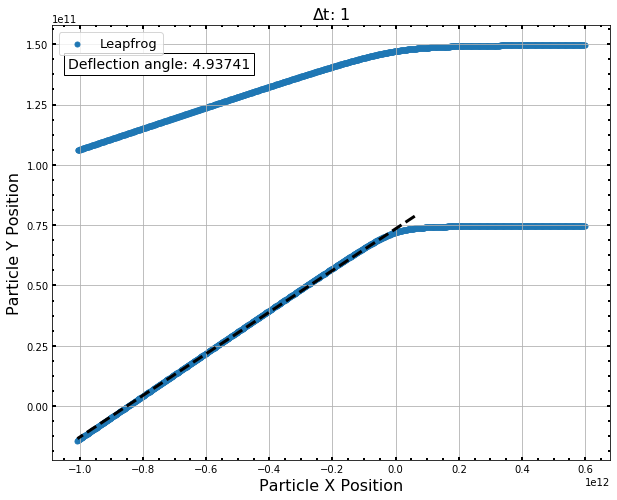

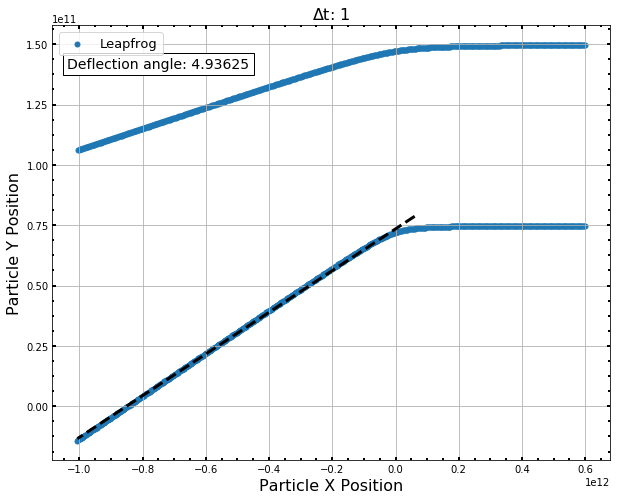

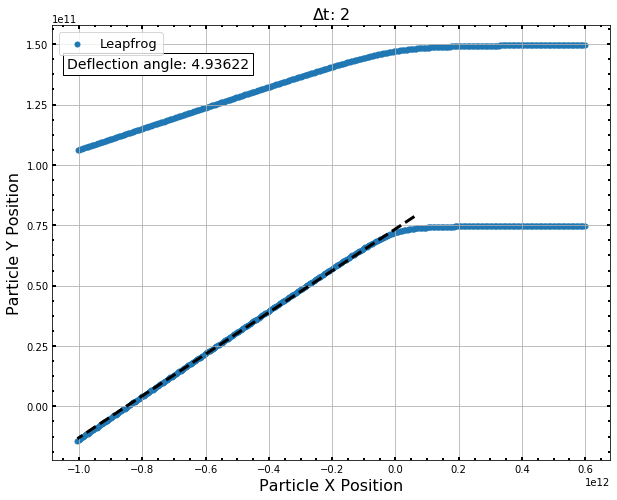

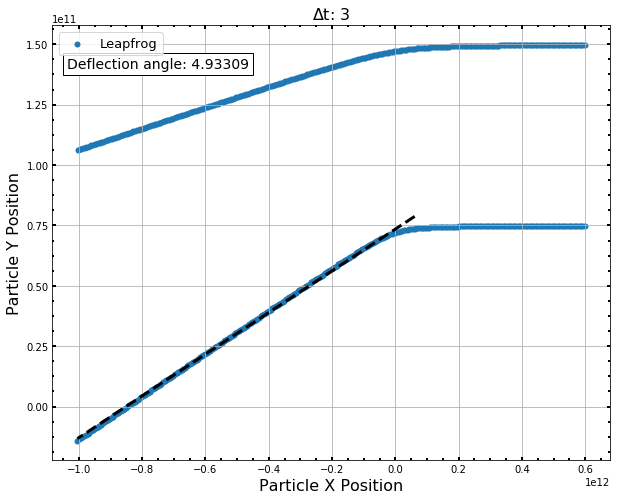

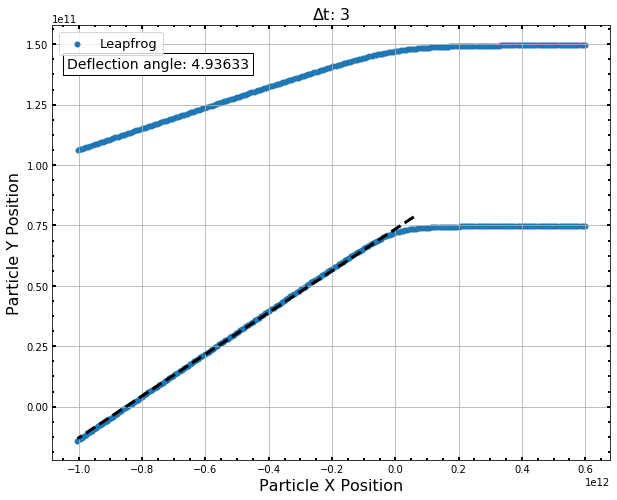

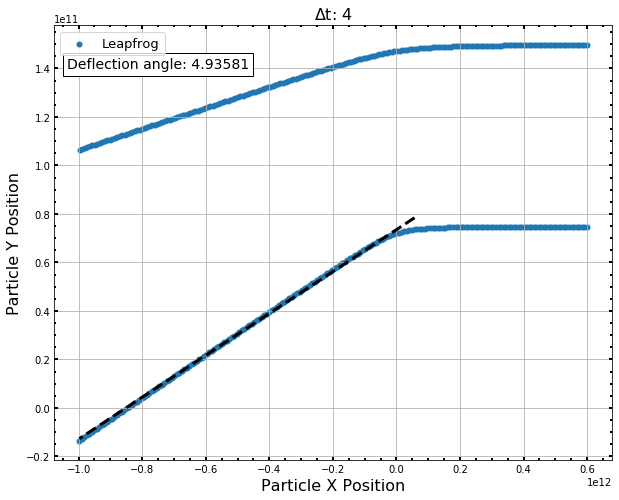

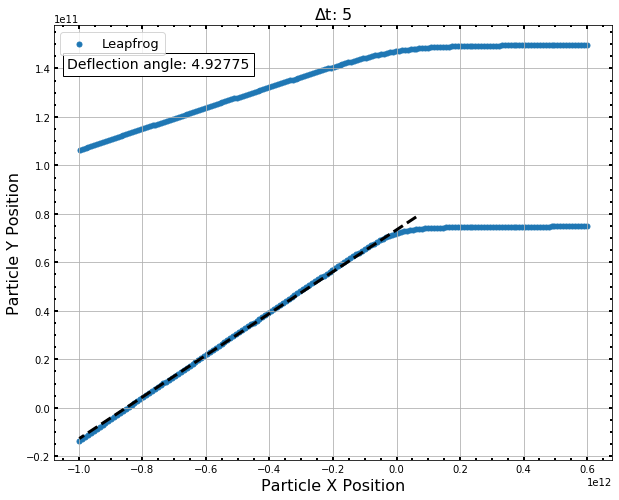

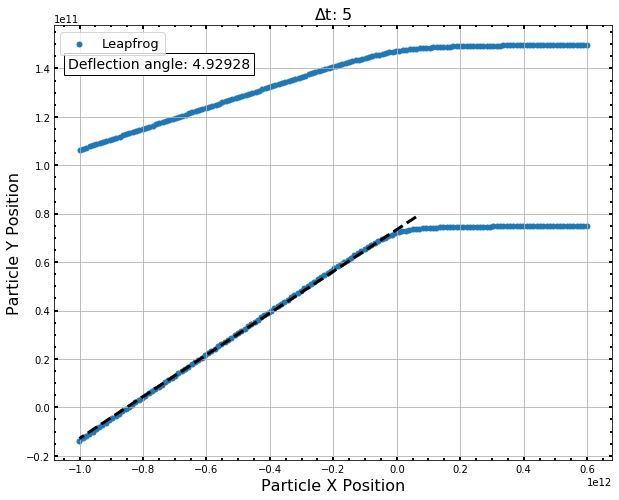

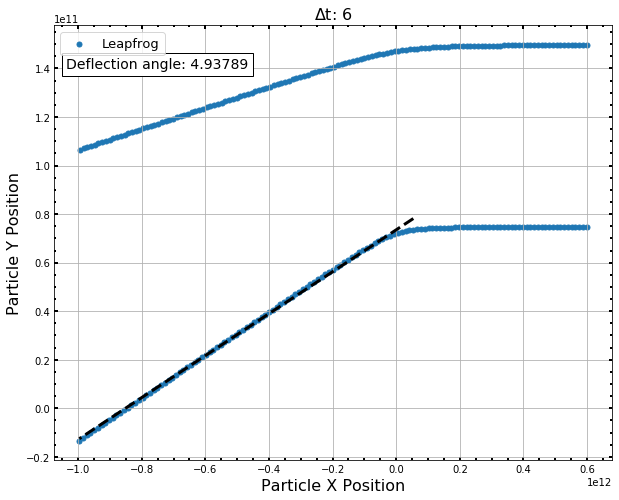

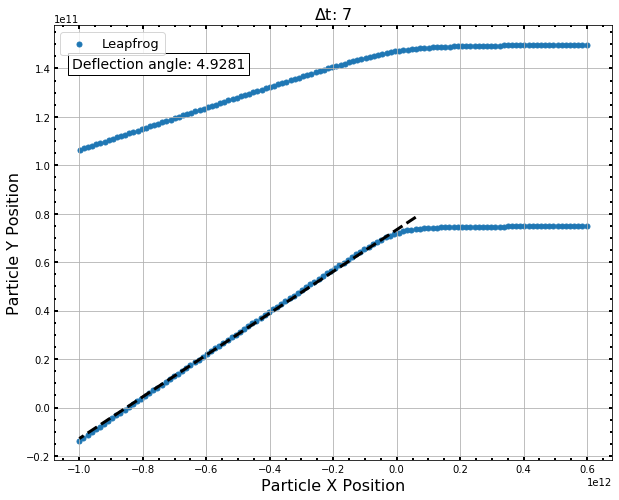

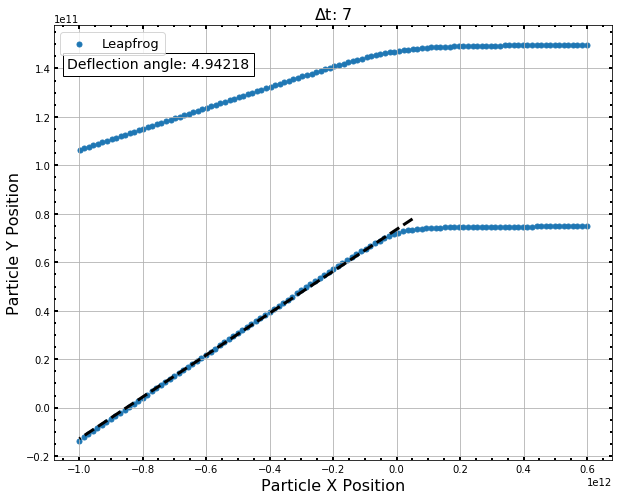

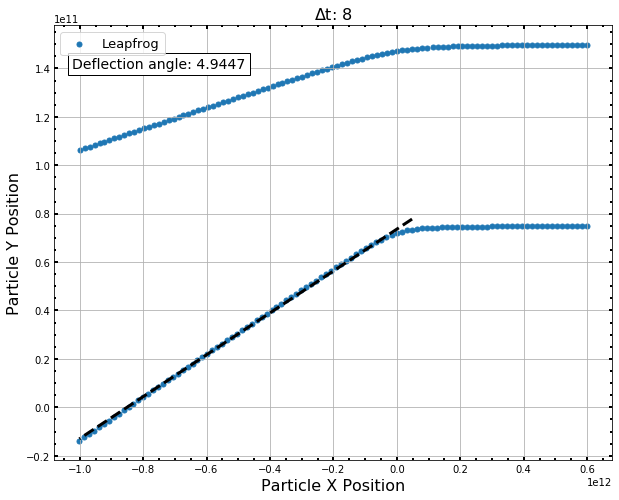

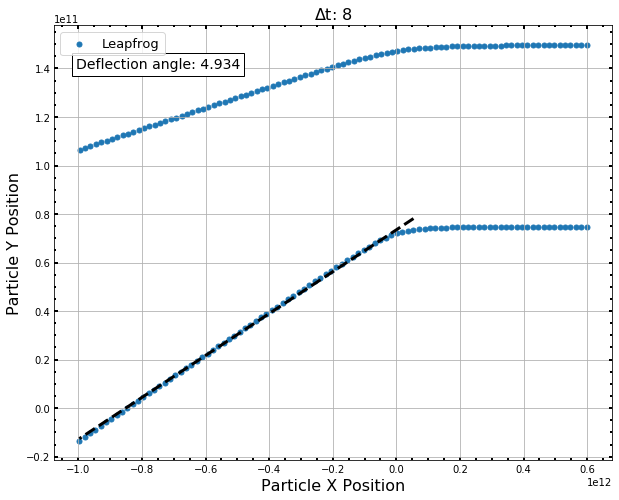

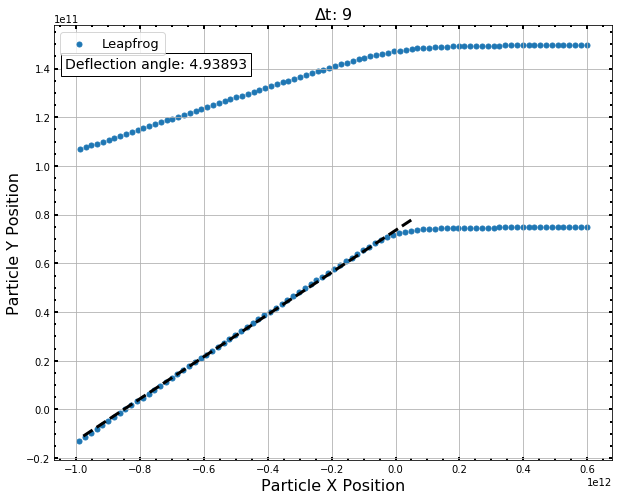

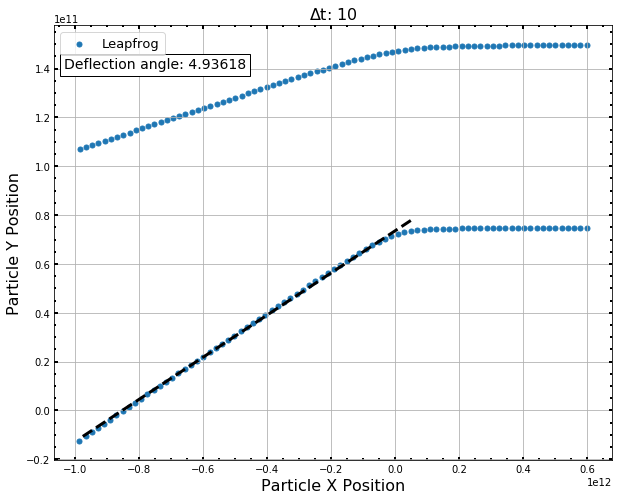

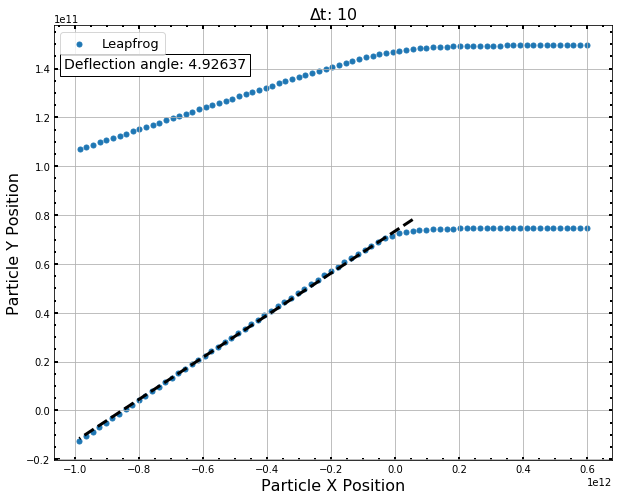

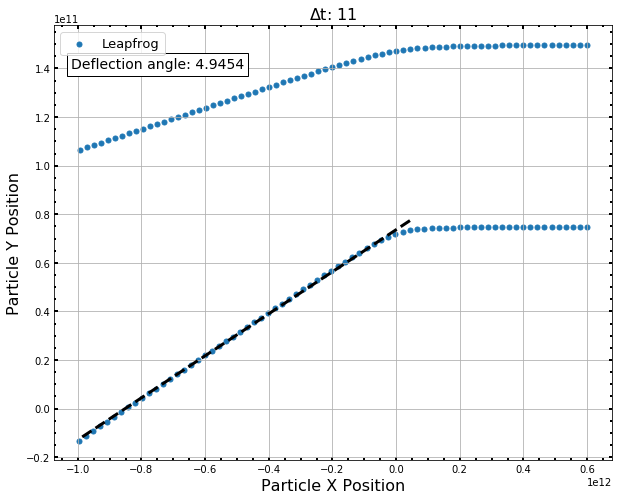

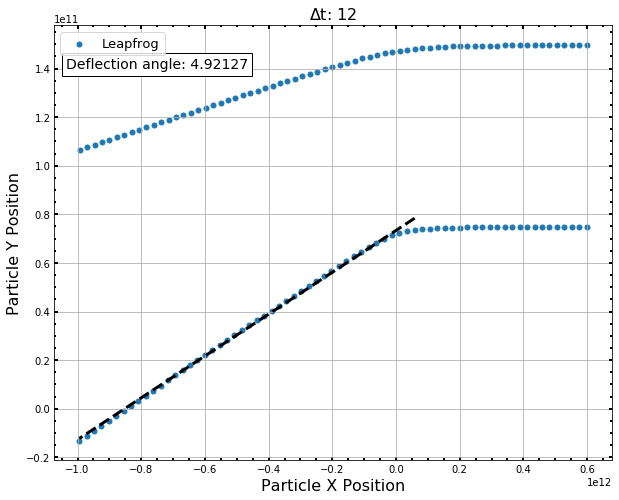

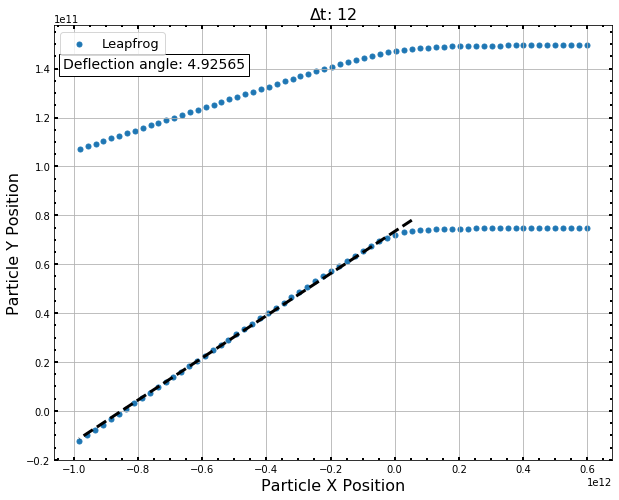

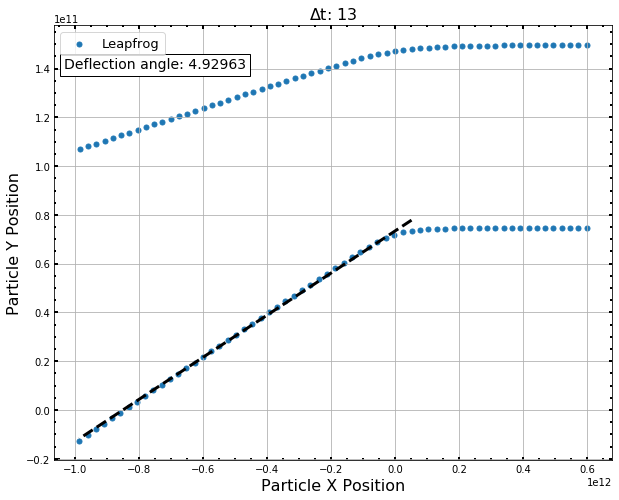

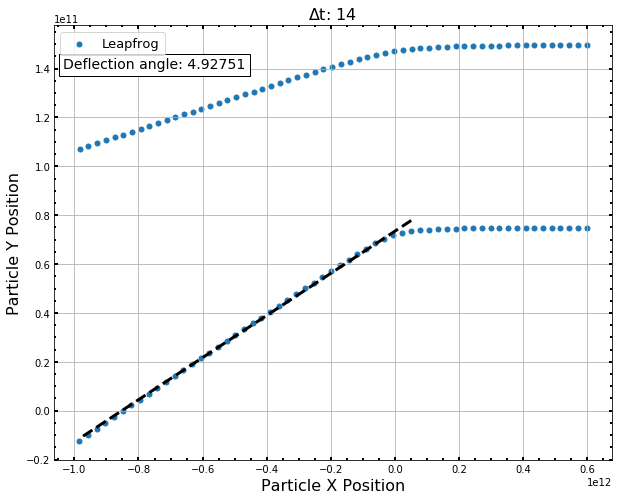

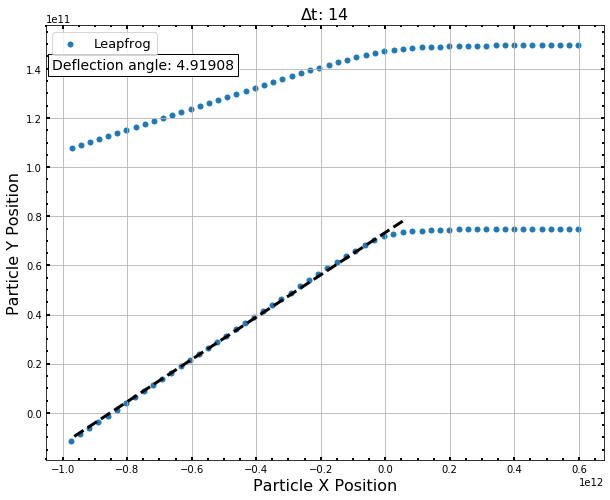

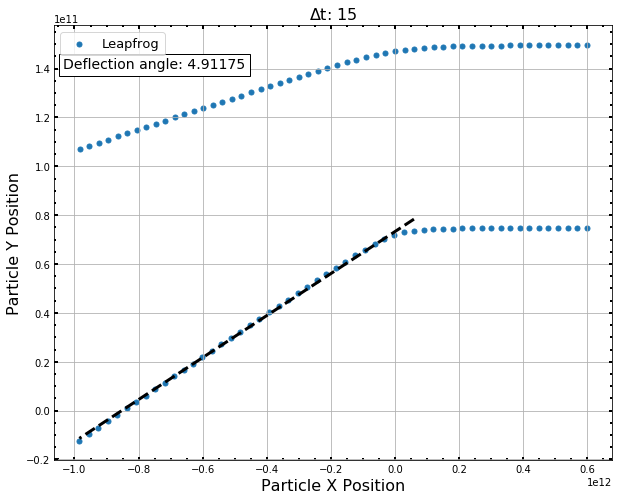

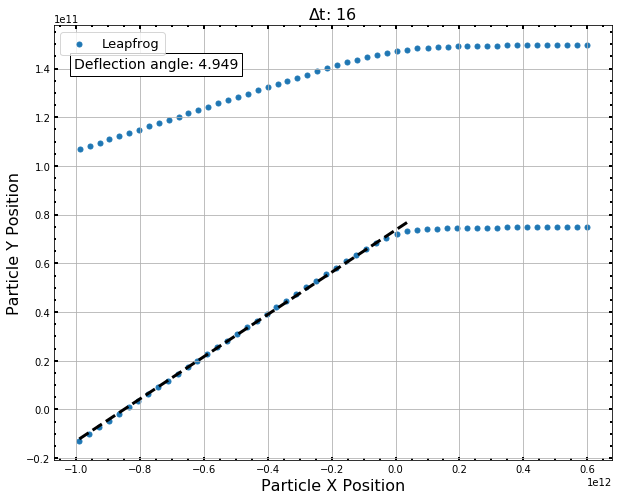

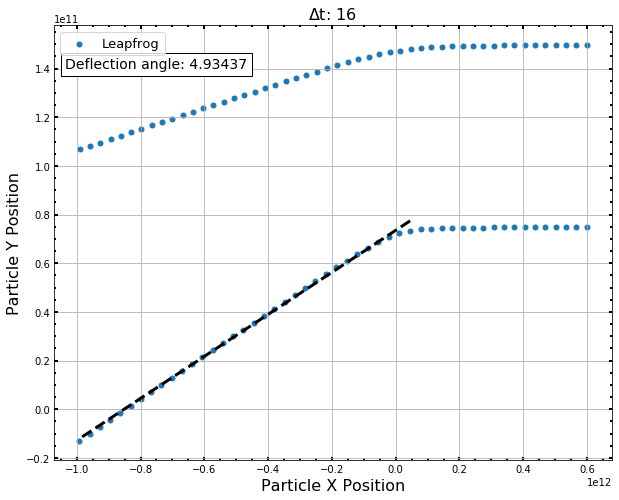

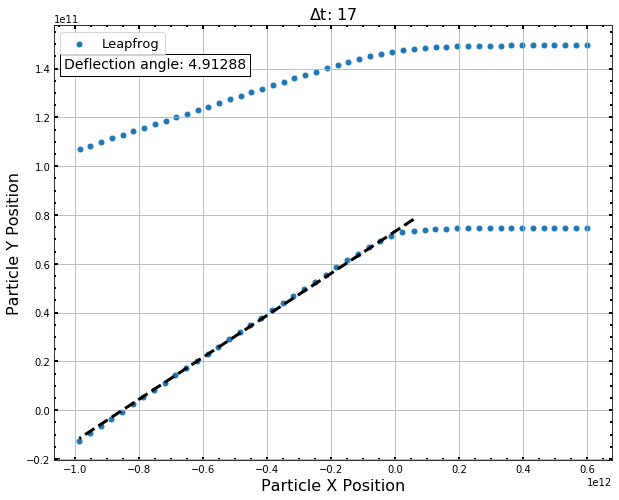

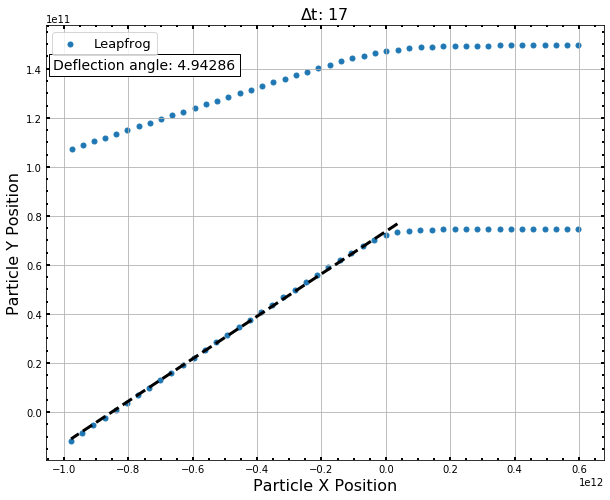

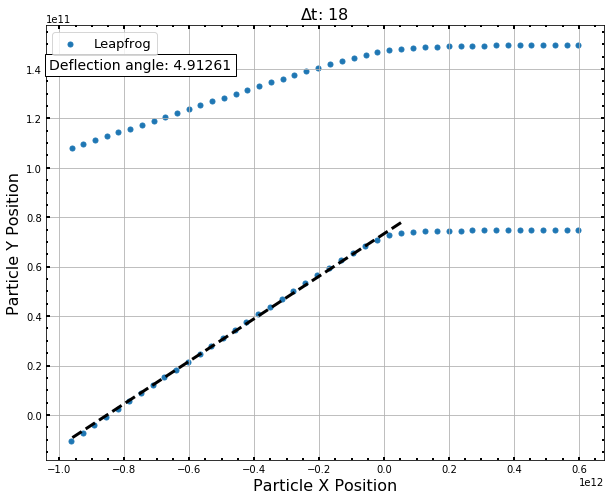

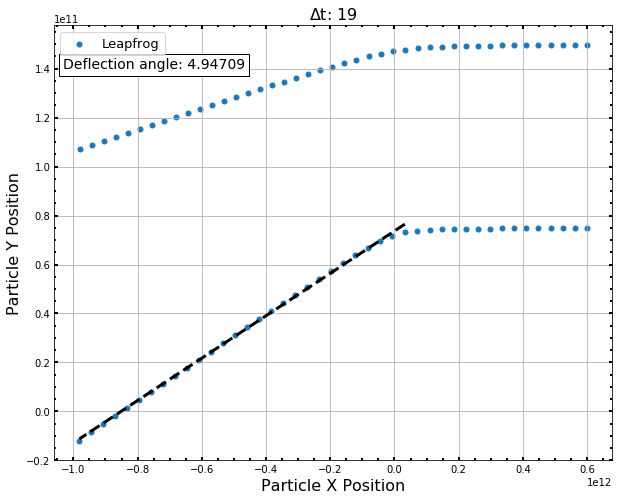

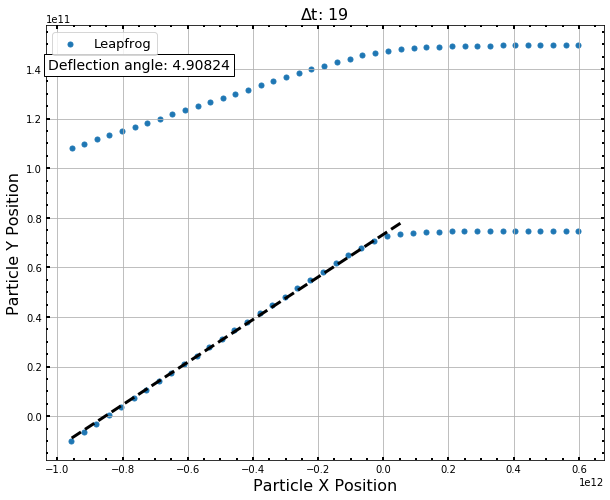

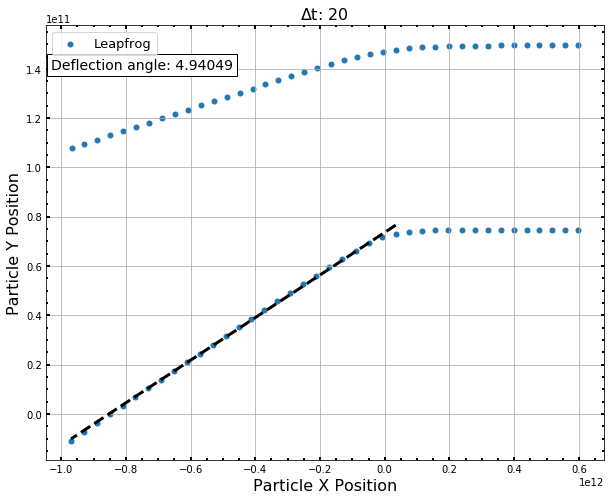

In [16]:
dts=np.linspace(0.1,20,32)
#dts=np.logspace(0.1,100,10)
time=800 #variable for how long the simulation will run for 

for i in range(len(dts)): 
    Nsteps=time/dts[i]
    Nsteps=int(np.round(Nsteps))
    xpos,ypos,xvel,yvel,xacc,yacc=leapfrog(xi,ymax,vi,Nsteps,2,dts[i])
    xpos_e,ypos_e,xvel_e,yvel_e,xacc_e,yacc_e=euler(xi,ymax,vi,Nsteps,2,dts[i])
    #print(ypos[0])
    cut = int(Nsteps/1.5)
    
    
    coef, poly1d_fn, angle = fit(xpos[0][-cut:],ypos[0][-cut:])
   
    
    fig, ax = plt.subplots(figsize=[10,8])
    ax.scatter(xpos,ypos,s=25,label='Leapfrog')
    ax.plot(xpos[0][-cut:], poly1d_fn(xpos[0][-cut:]), '--k',lw=3)
    ax.legend(fontsize=13)
    ax.set_title('$\Delta$t: {:d}'.
             format(int(np.round(dts[i]))),fontsize=16)
    ax.set_xlabel('Particle X Position',fontsize=16)
    ax.set_ylabel('Particle Y Position',fontsize=16)
    ax.tick_params(which='both', direction='in',width=2)
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    plt.grid(True)
    #plt.text(-0.95e12,1.3e11, '$\Delta$t: {:d}'.
     #        format(int(np.round(angle[i]))),horizontalalignment='center',bbox={'facecolor':'w'},fontsize=14)
    plt.text(-0.75e12,1.4e11, 'Deflection angle: {:g}'.
             format(angle),horizontalalignment='center',bbox={'facecolor':'w'},fontsize=14)
    
    #print('dt,slope, intercept, Angle:',int(np.round(dts[i])),coef, angle)
    

/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RankWarning: Polyfit may be poorly conditioned
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RankWarning: Polyfit may be poorly conditioned
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned


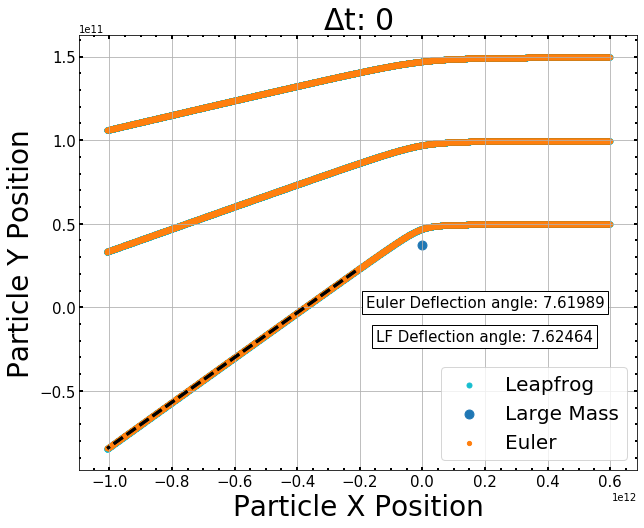

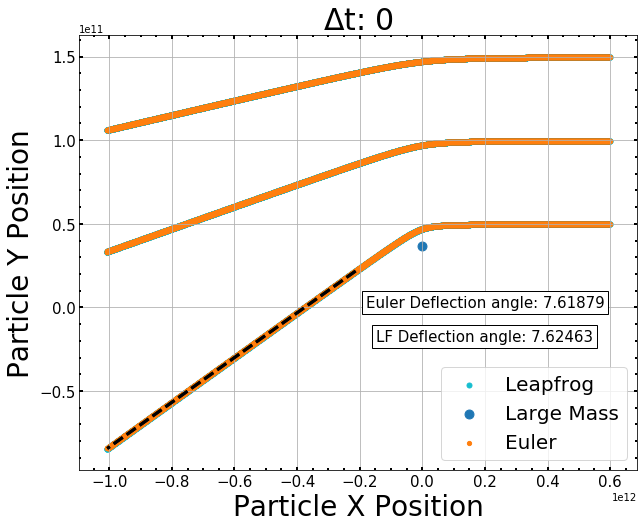

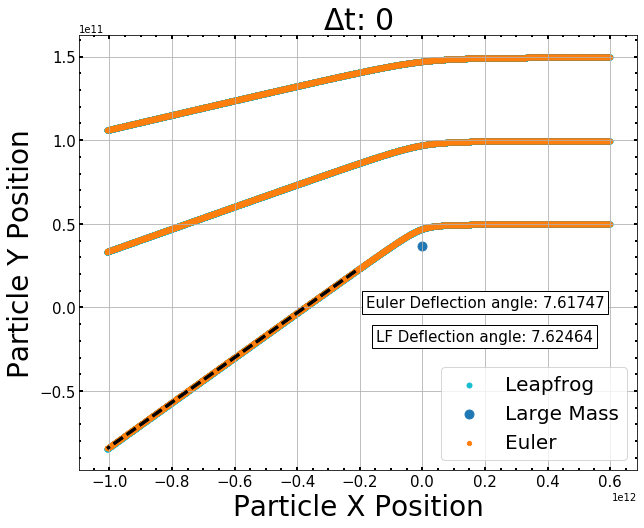

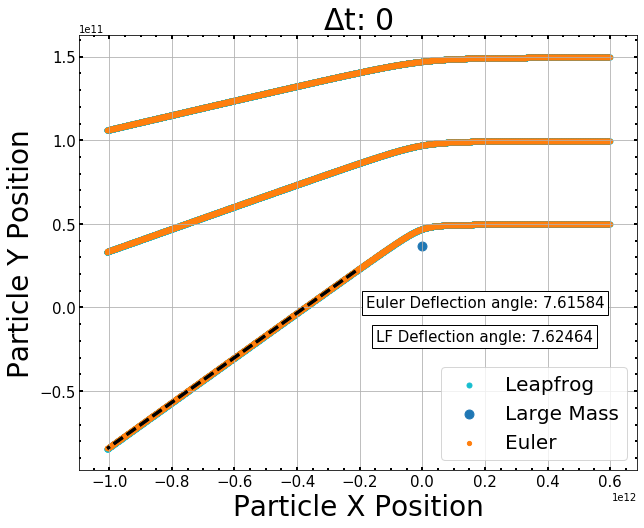

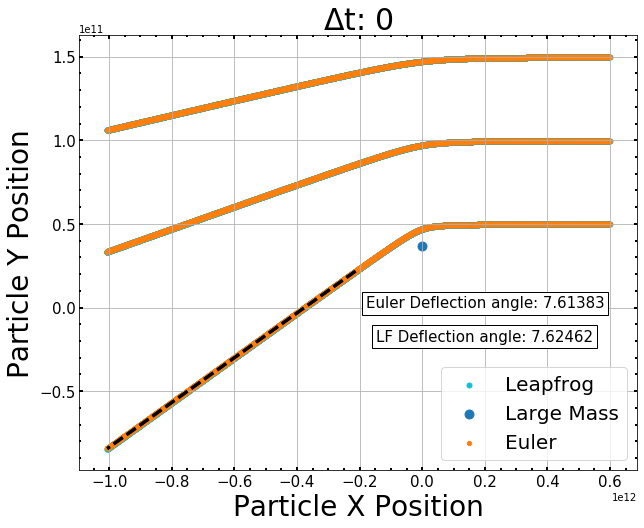

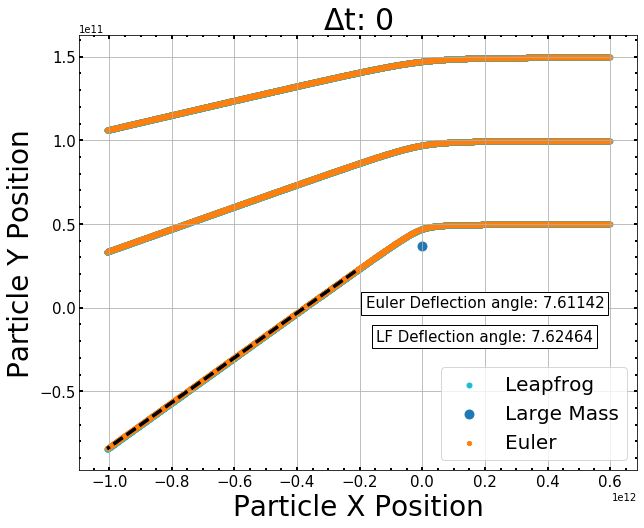

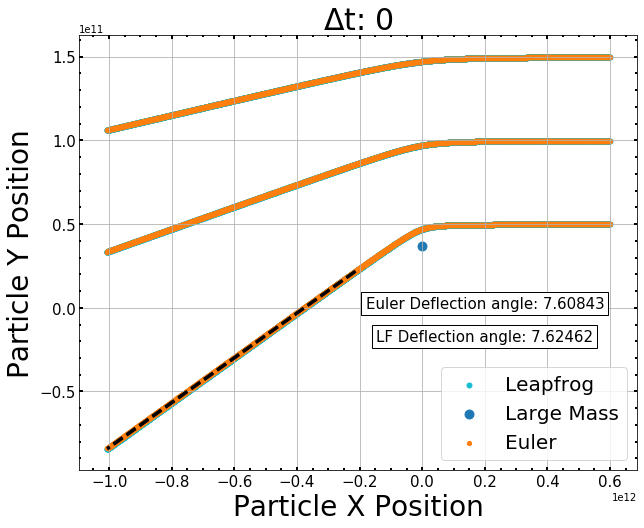

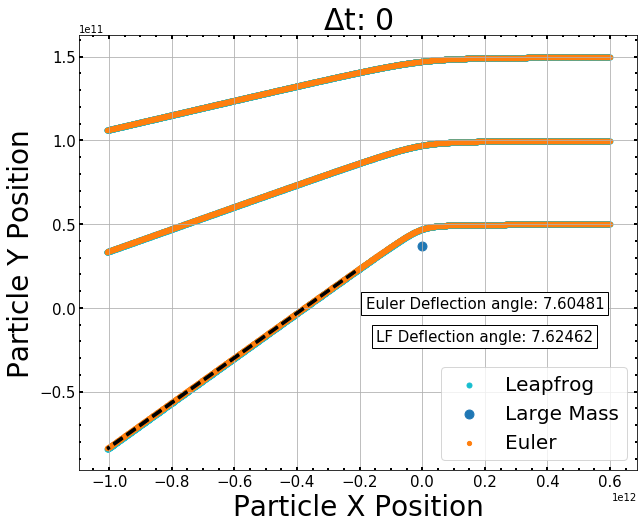

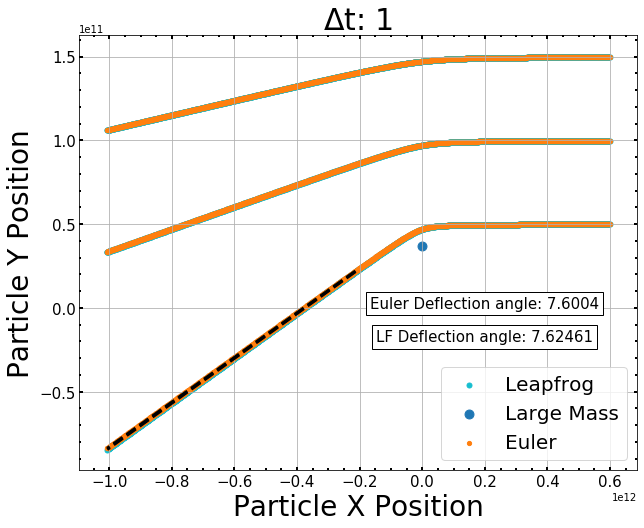

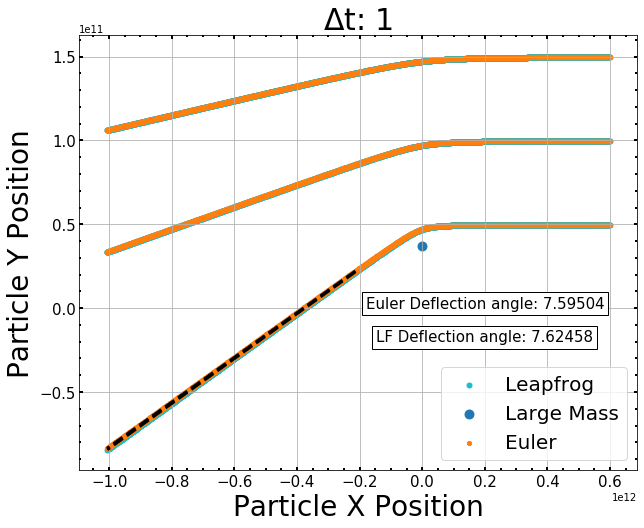

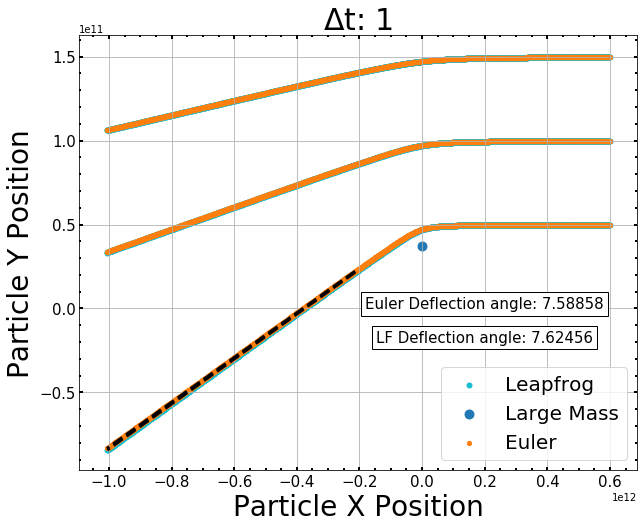

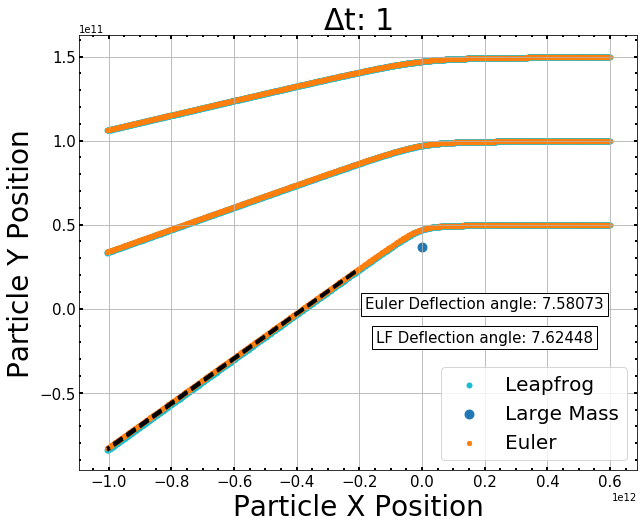

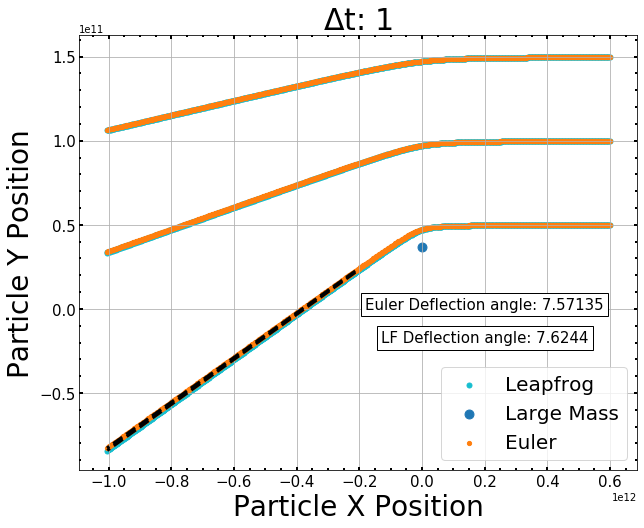

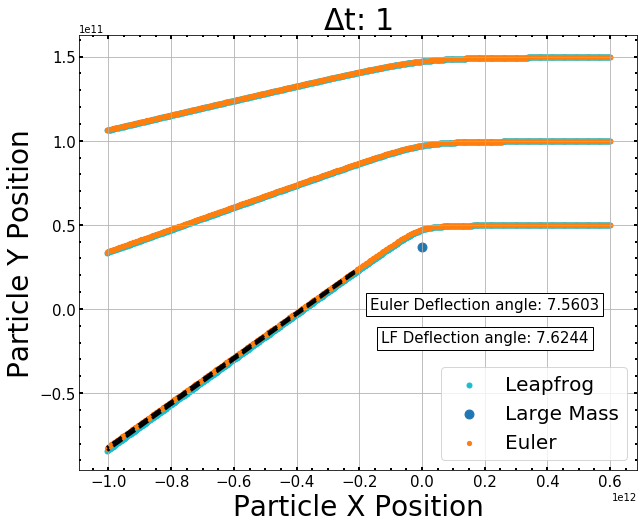

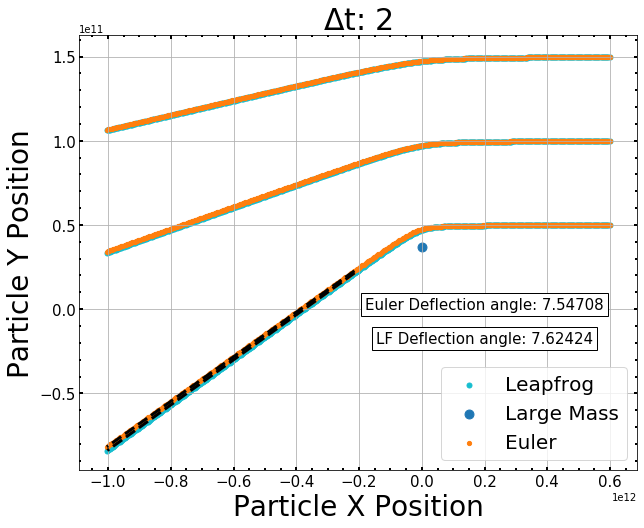

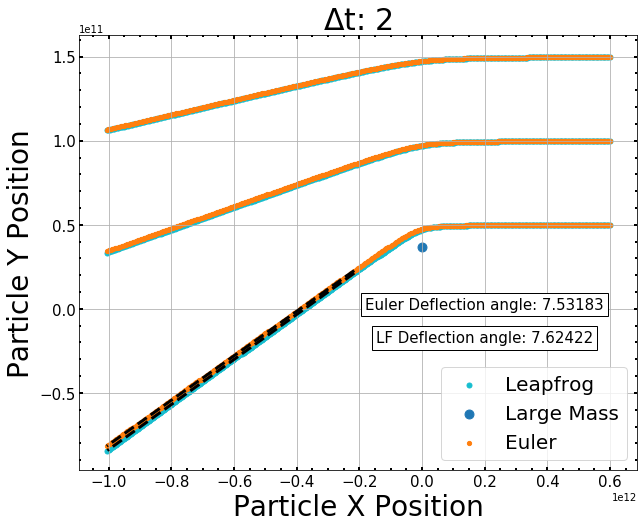

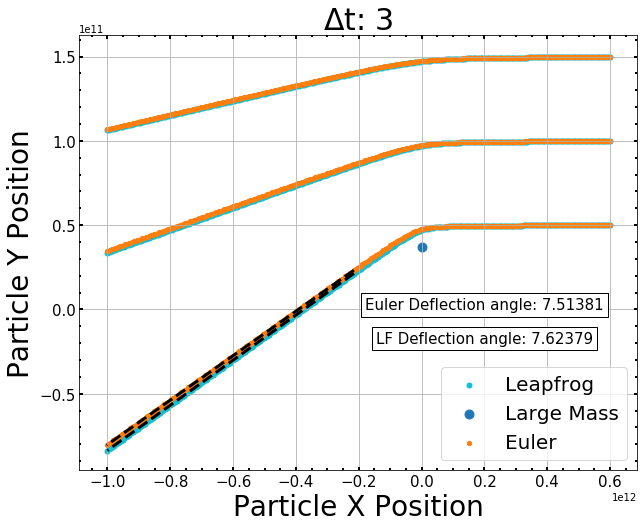

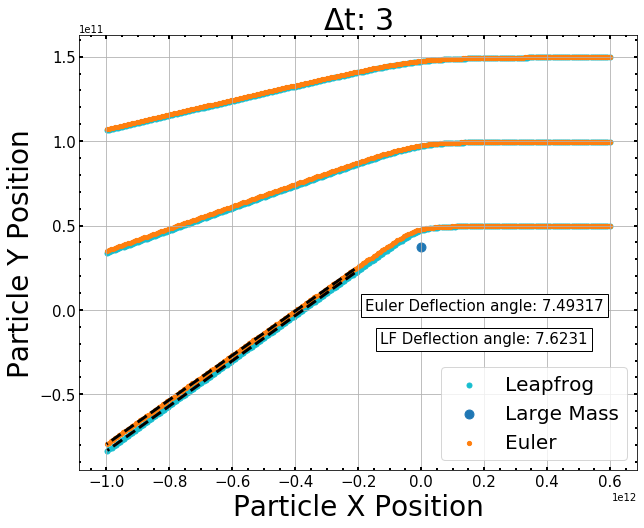

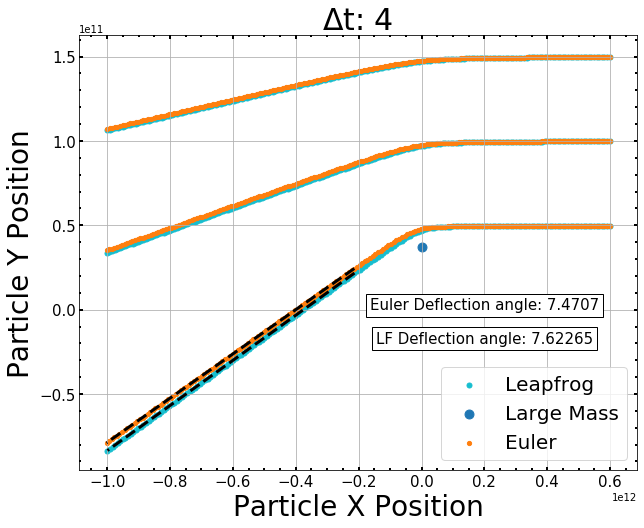

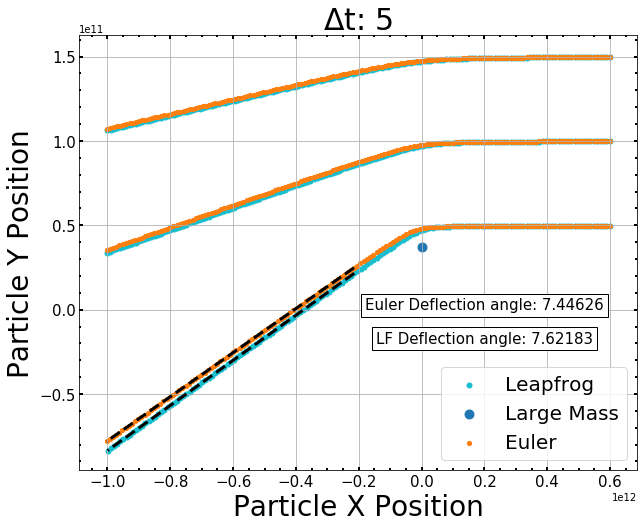

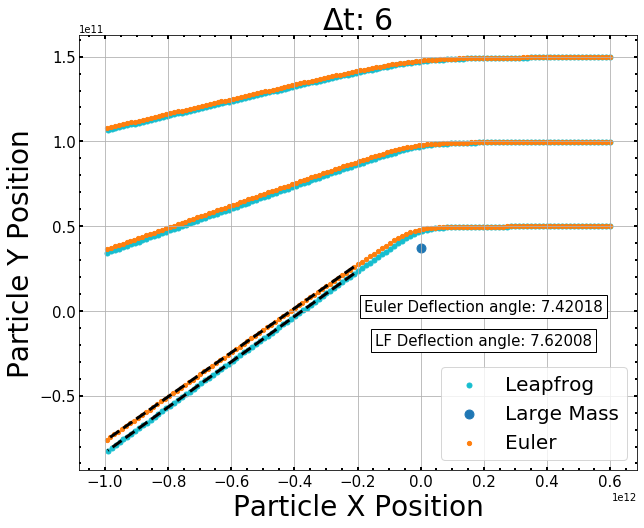

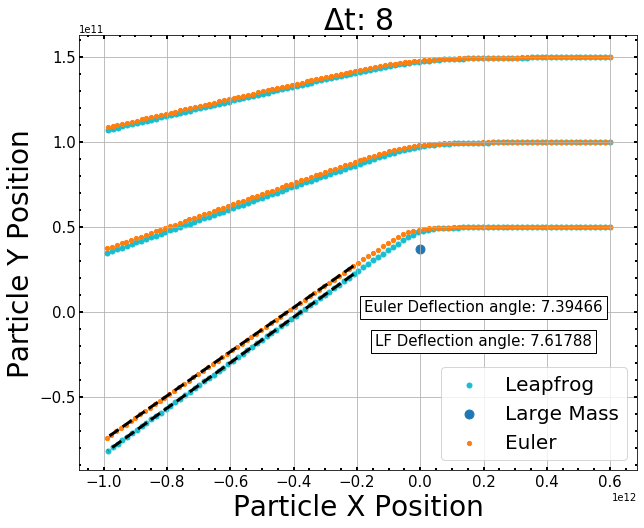

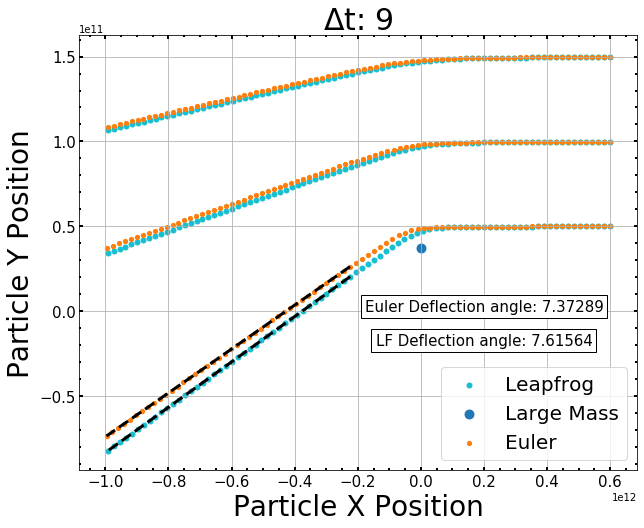

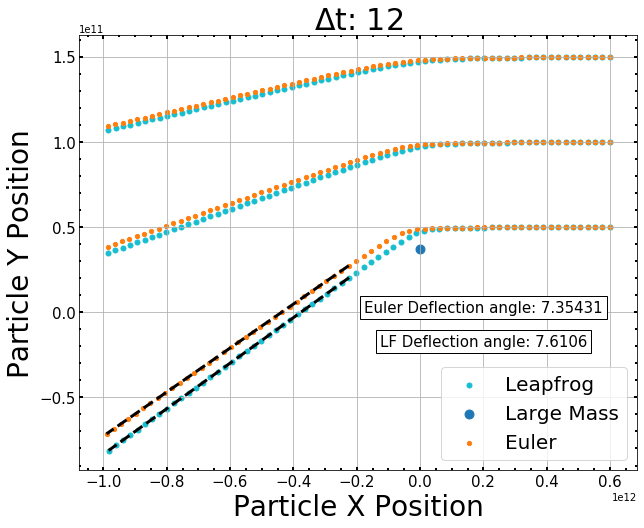

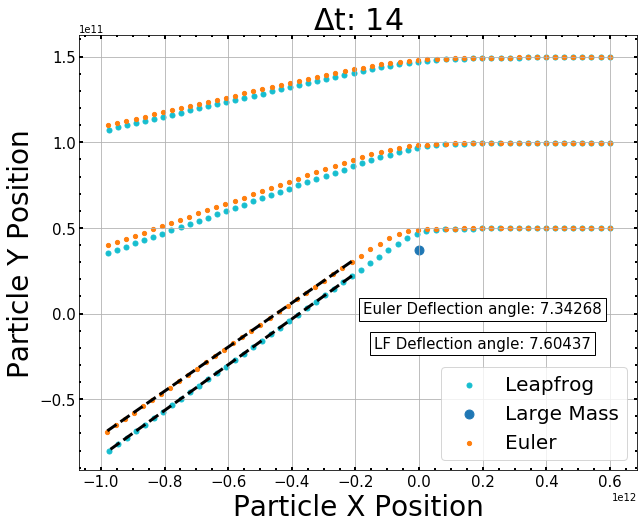

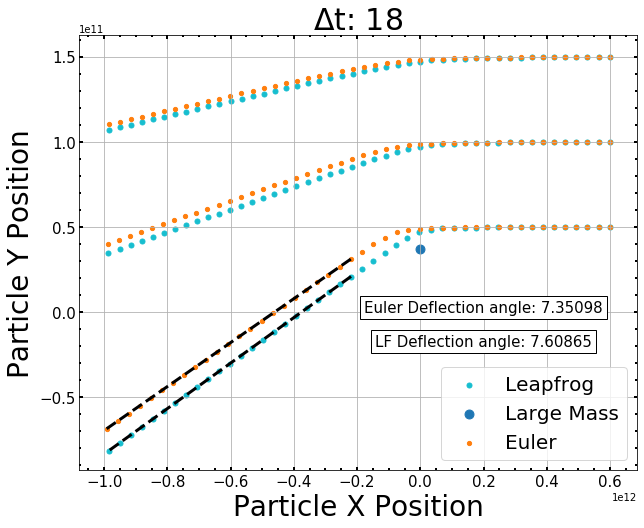

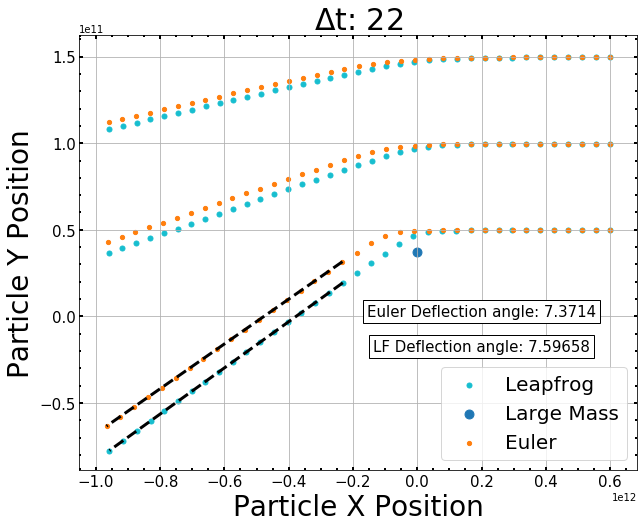

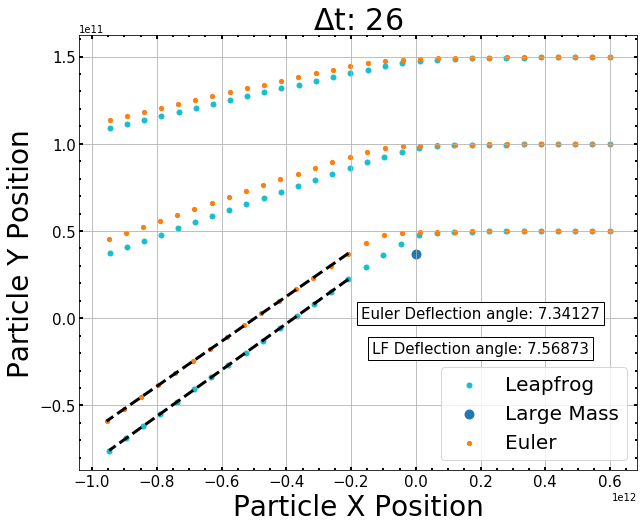

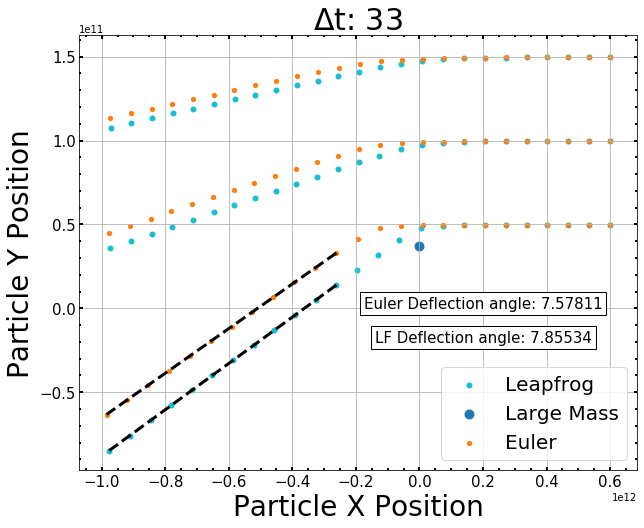

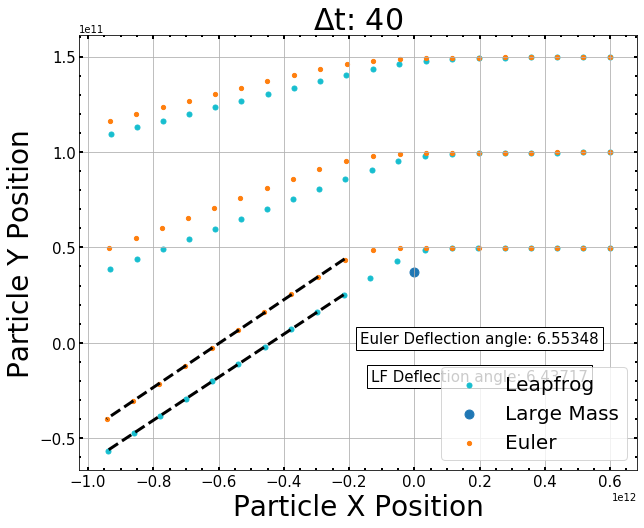

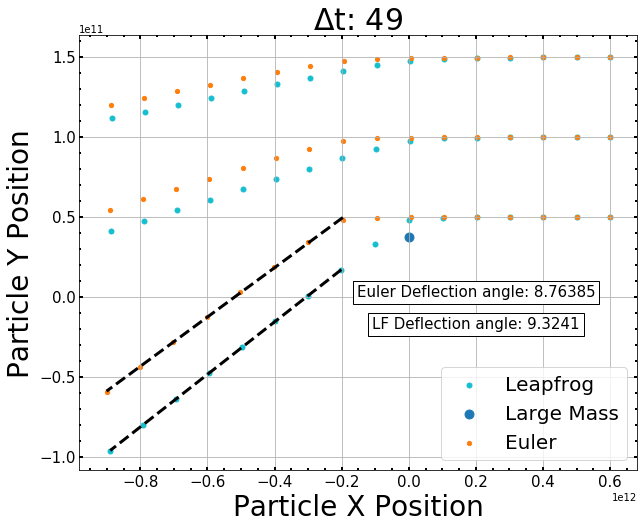

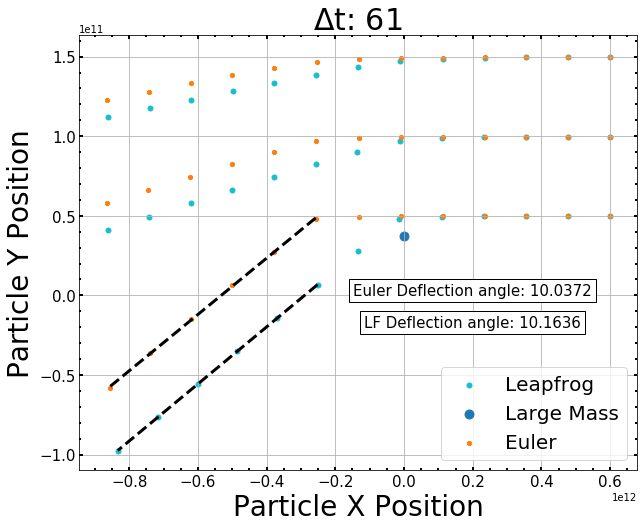

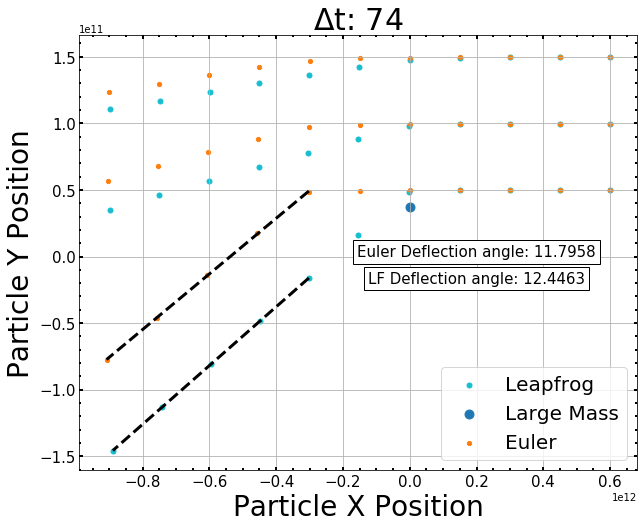

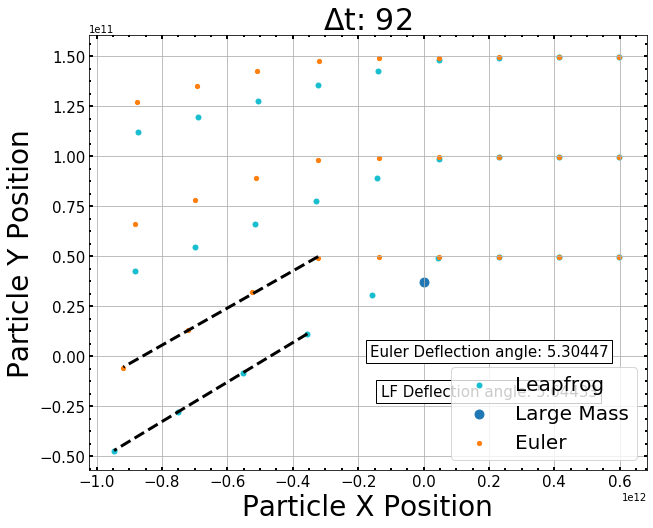

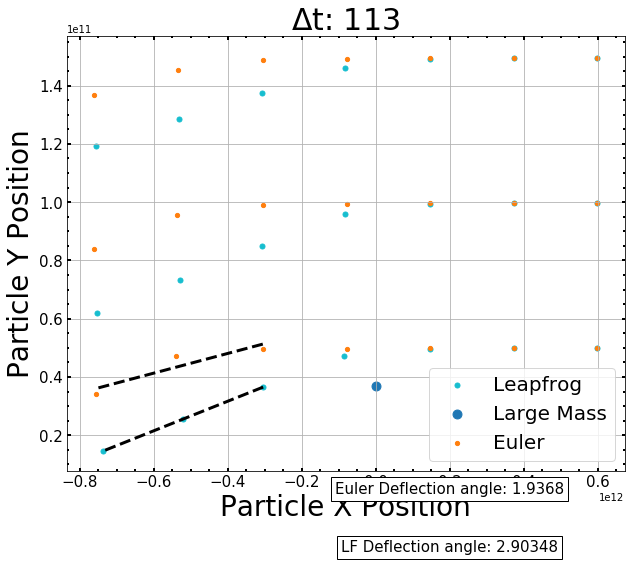

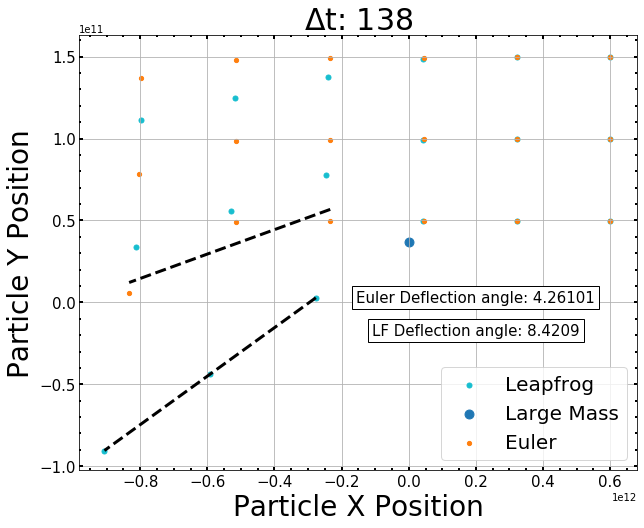

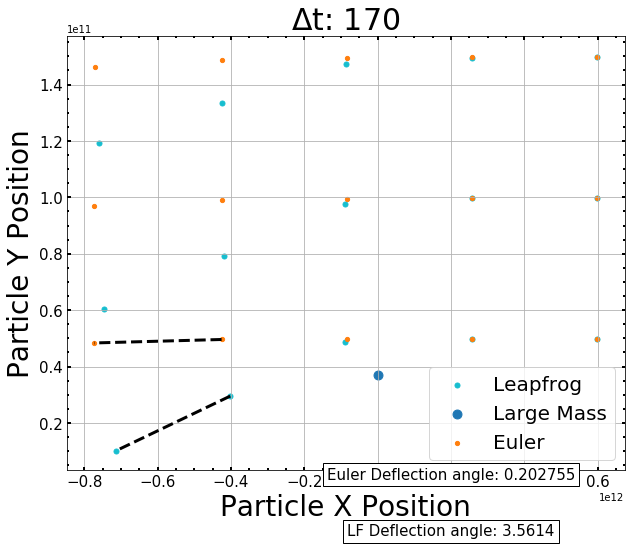

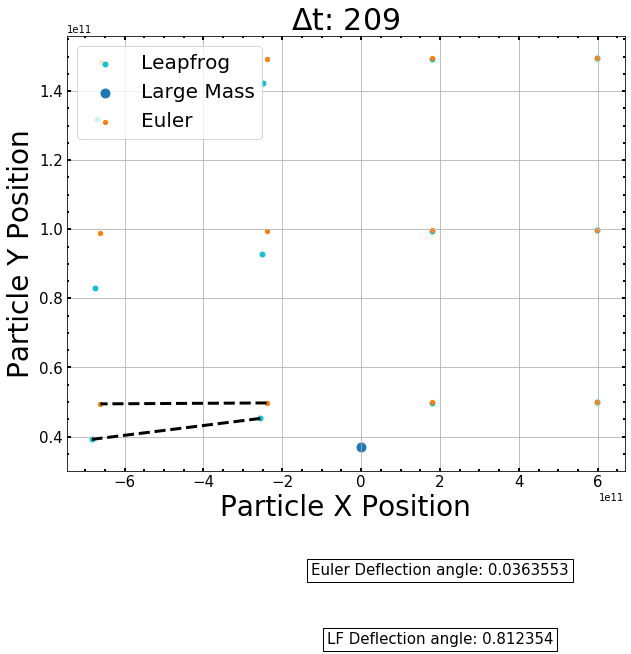

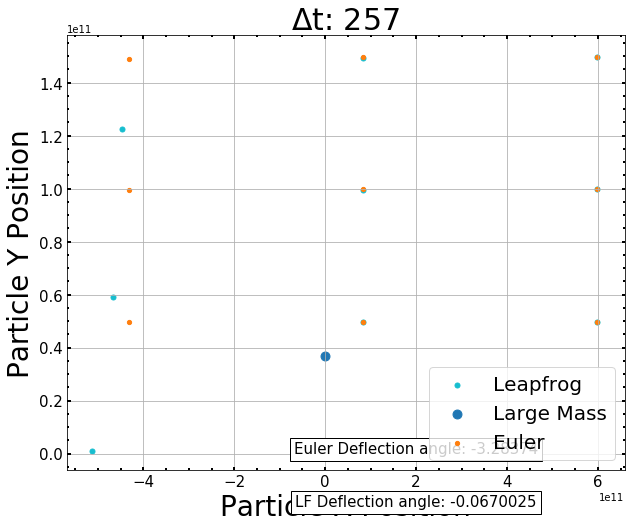

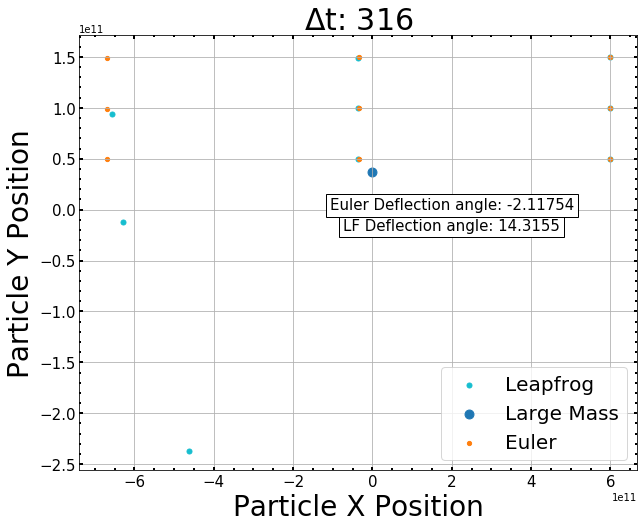

In [14]:
#dts=np.linspace(0.1,20,32)
dts=np.logspace(-1,2.5,40)
time=800 #variable for how long the simulation will run for 
x_pos=np.zeros((len(dts),8000))
y_pos=np.zeros((len(dts),8000))
x_vel=np.zeros((len(dts),8000))
y_vel=np.zeros((len(dts),8000))
x_acc=np.zeros((len(dts),8000))
y_acc=np.zeros((len(dts),8000))
AnglesLF = []
AnglesE = []

for i in range(len(dts)): 
    #if dts[i]<...:
    #else
    Nsteps=time/dts[i]
    Nsteps=int(np.round(Nsteps))
    xpos,ypos,xvel,yvel,xacc,yacc=leapfrog(xi,ymax,vi,Nsteps,3,dts[i])
    xpos_e,ypos_e,xvel_e,yvel_e,xacc_e,yacc_e=euler(xi,ymax,vi,Nsteps,3,dts[i])
    
    cut = int(Nsteps/2)
    
    
    coef, poly1d_fn, angle = fit(xpos[0][-cut:],ypos[0][-cut:])
    coefE,poly1d_fnE,angleE= fit(xpos_e[0][-cut:],ypos_e[0][-cut:])
    AnglesLF.append(angle)
    AnglesE.append(angleE)
    
    fig, ax = plt.subplots(figsize=[10,8])
    ax.scatter(xpos,ypos,s=25,color='tab:cyan',label='Leapfrog')
    ax.scatter(0,0.37e11, s=80, label="Large Mass")
    ax.plot(xpos[0][-cut:], poly1d_fn(xpos[0][-cut:]), '--k',lw=3)
    #ax.plot(np.linspace(0,200,100),np.ones(100)*7.613081715977086,':k',lw=2.5, label='B&T Angle:')
    ax.scatter(xpos_e,ypos_e,s=18,color='tab:orange',label='Euler')
    ax.plot(xpos_e[0][-cut:], poly1d_fnE(xpos_e[0][-cut:]), '--k',lw=3)
    ax.legend(fontsize=20)
    ax.set_title('$\Delta$t: {:d}'.
             format(int(np.round(dts[i]))),fontsize=30)
    ax.set_xlabel('Particle X Position',fontsize=28)
    ax.set_ylabel('Particle Y Position',fontsize=28)
    ax.tick_params(which='both', direction='in',width=2)
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis="x", labelsize=15)
    ax.tick_params(axis="y", labelsize=15)
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    plt.grid(True)
    #plt.text(-0.95e12,1.3e11, '$\Delta$t: {:d}'.
     #        format(int(np.round(angle[i]))),horizontalalignment='center',bbox={'facecolor':'w'},fontsize=14)
    plt.text(0.2e12,-0.2e11, 'LF Deflection angle: {:g}'.
             format(angle),horizontalalignment='center',bbox={'facecolor':'w'},fontsize=15)
    plt.text(0.2e12,0, 'Euler Deflection angle: {:g}'.
            format(angleE),horizontalalignment='center',bbox={'facecolor':'w'},fontsize=15)
    
    #print(dt,slope, intercept, Angle:',int(np.round(dts[i])),coef, angle)
    

/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:2559: UserWarning: AutoMinorLocator does not work with logarithmic scale
  warnings.warn('AutoMinorLocator does not work with logarithmic '


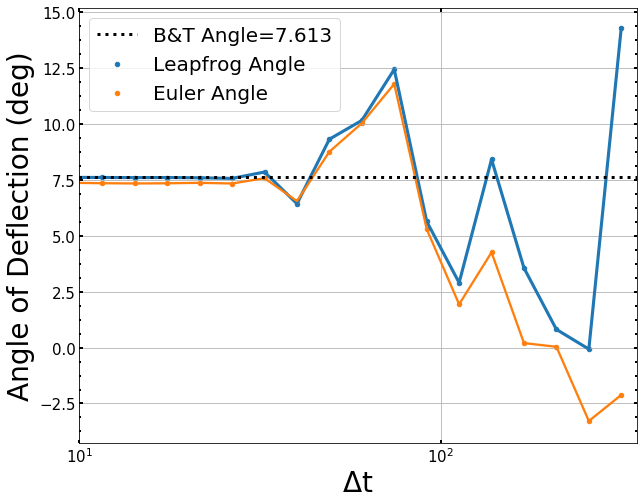

In [15]:
fig, ax = plt.subplots(figsize=[10,8])
ax.scatter(dts,AnglesLF,s=20,color='tab:blue',label='Leapfrog Angle')
ax.plot(dts,AnglesLF,color='tab:blue',lw=3.1)
ax.scatter(dts,AnglesE,s=20,color='tab:orange',label='Euler Angle')
ax.plot(dts,AnglesE,color='tab:orange',lw=2.3)
#ax.plot(np.ones(10)*2.5410175957145036,np.linspace(0,6,10),'k--',label='B&T Angle Value')
ax.plot(np.linspace(0,400,100),np.ones(100)*7.613081715977086,':k',label='B&T Angle=7.613',lw=3)
ax.set_xscale('log')
ax.set_xlim(10,350)
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)
ax.legend(fontsize=20)
ax.tick_params(which='both', direction='in',width=2)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.set_xlabel('$\Delta$t',fontsize=28)
ax.set_ylabel('Angle of Deflection (deg)',fontsize=28)
plt.grid(True)

# Setting new IC's and longer simulation run times

In [28]:
#Defining Variables and constants

Big_M = (1e8 * const.M_sun.value) #kg
Obj_Radius = 0.1 * const.au.value # m
Small_M = const.M_sun.value
vi = 2e7 #m/s
xi = (10**4)*4*const.au.value
ymax = 10**4*const.au.value  #m
ypos=np.linspace(0,1,int(N)+1)[1:]*(ymax)


    
dt = 10 # second time step
N = 50 #Number of steps 


colors = mpl.cm.get_cmap()(np.linspace(0.0, 1.0, int(N))) # setting colors for data pts


escape_vel= np.sqrt(2*const.G.value * Big_M/xi)
print(f"escape velocity = {escape_vel/1e5:.4e}")
escape_time = xi/(escape_vel * vi)
#print(f"escape time = {time:.4e}")
dt,ymax

escape velocity = 2.1061e+01


(10, 1495978707000000.0)

In [29]:
#defining my motion functions in order to place inside leapfrog function for loop
def Position(x,vx,ax,dt):
    x = x + vx * dt + 0.5*(ax)*dt**2
    return x

def Acceleration(xpos,ypos):
    a = ((-const.G.value*Big_M/((xpos**2+ypos**2)**(3/2))))
    return a

def Velocity(vx,ax,ax_1,dt):
    vx = vx + 0.5*(ax + ax_1)*dt
    return vx
    

In [30]:
#Leapfrog for 10 particle DUPLICATE not using second for loop and using a functio for the entire calculation. 
def leapfrog(xi,ymax,vi,N,P,dt):

    x = np.ones(P)*xi
    y = np.linspace(0,1,int(P)+1)[1:]*(ymax)
    vx = np.ones(P)*(-vi)
    vy = np.zeros(P)


    Xpos=np.zeros((P,N))
    Ypos=np.zeros((P,N))
    Xvel=np.zeros((P,N))
    Yvel=np.zeros((P,N))
    Xacc=np.zeros((P,N))
    Yacc=np.zeros((P,N))

    Xpos[:,0]=x
    Ypos[:,0]=y
    Xvel[:,0]=vx
    Yvel[:,0]=vy
    Xacc[:,0]=((-const.G.value*Big_M/((Xpos[:,0]**2+Ypos[:,0]**2)**(3/2)))*Xpos[:,0])
    Yacc[:,0]=((-const.G.value*Big_M/((Xpos[:,0]**2+Ypos[:,0]**2)**(3/2)))*Ypos[:,0])
    for i in range(N-1):
        #for j in range(p):

        Xpos[:,i+1] = Position(Xpos[:,i],Xvel[:,i],Xacc[:,i],dt)
            #Xpos[j,i+1] = Xpos[j,i] + Xvel[j,i] *dt + 0.5*(Xacc[j,i])*dt**2 
        Ypos[:,i+1] = Position(Ypos[:,i],Yvel[:,i],Yacc[:,i],dt) 

            #print(Xpos) #The x pos at this point is giving iterating up to N=1

        Acc=Acceleration(Xpos[:,i+1],Ypos[:,i+1]) 
        Xacc[:,i+1] = Acc*Xpos[:,i+1]
        Yacc[:,i+1] = Acc*Ypos[:,i+1]

        Xvel[:,i+1] = Velocity(Xvel[:,i],Xacc[:,i],Xacc[:,i+1],dt)
        Yvel[:,i+1] = Velocity(Yvel[:,i],Yacc[:,i],Yacc[:,i+1],dt)
            #we can do vels for every particle at one time
        
    return Xpos, Ypos, Xvel, Yvel, Xacc, Yacc
    


In [31]:
#defining velocity and position functions that will be used in the euler function below
def vel(vx,x_acc,dt):
    vx=vx+x_acc*dt
    return vx

def pos(x,vx,dt):
    x=x+vx*dt
    return x


#Rewriting Euler integration in a function format and using array operations in one for loop

def euler(xi,ymax,vi,N,P,dt):
    vy = np.zeros(P)
    vx = np.ones(P)*(-vi)
    y=np.linspace(0,1,int(P)+1)[1:]*(ymax)
    x = np.ones(P)*xi

    Time_e = np.zeros((P,N))     
    Xpos_e = np.zeros((P,N))
    Ypos_e = np.zeros((P,N))
    Yvel_e = np.zeros((P,N))
    Xvel_e = np.zeros((P,N))
    Xacc_e=np.zeros((P,N))
    Yacc_e=np.zeros((P,N))

    Xpos_e[:,0]=x
    Ypos_e[:,0]=y
    Xvel_e[:,0]=vx
    Yvel_e[:,0]=vy
    Xacc_e[:,0]=((-const.G.value*Big_M/((Xpos_e[:,0]**2+Ypos_e[:,0]**2)**(3/2)))*Xpos_e[:,0])
    Yacc_e[:,0]=((-const.G.value*Big_M/((Xpos_e[:,0]**2+Ypos_e[:,0]**2)**(3/2)))*Ypos_e[:,0])

    for i in range(N-1): #Avoid square arrays!!!
        #print("i=", i)
        Xacc_e[:,i+1] = Acceleration(Xpos_e[:,i],Ypos_e[:,i])*Xpos_e[:,i]
        Yacc_e[:,i+1] = Acceleration(Xpos_e[:,i],Ypos_e[:,i])*Ypos_e[:,i]
        Xvel_e[:,i+1] = vel(Xvel_e[:,i],Xacc_e[:,i],dt)
        Yvel_e[:,i+1] = vel(Yvel_e[:,i],Yacc_e[:,i],dt)
        Xpos_e[:,i+1] = pos(Xpos_e[:,i],Xvel_e[:,i],dt)
        Ypos_e[:,i+1] = pos(Ypos_e[:,i],Yvel_e[:,i],dt)

    return Xpos_e,Ypos_e,Xvel_e,Yvel_e,Xacc_e,Yacc_e


In [32]:
Xpos, Ypos, Xvel, Yvel, Xacc, Yacc = leapfrog(xi,ymax,vi,2000,3,8)

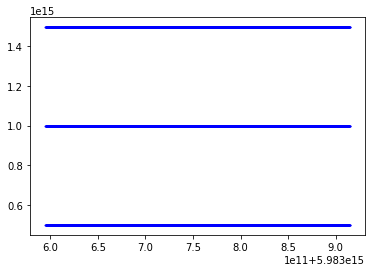

In [33]:
plt.scatter(Xpos, Ypos,s=1,color='blue');
#plt.xlim(-0.2e13,0.2e13)
#plt.ylim(-0.5e12,0.25e12);

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned


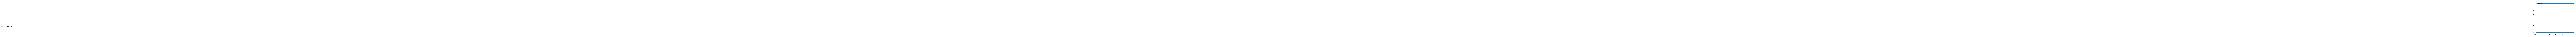

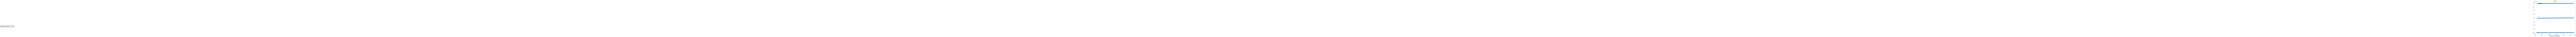

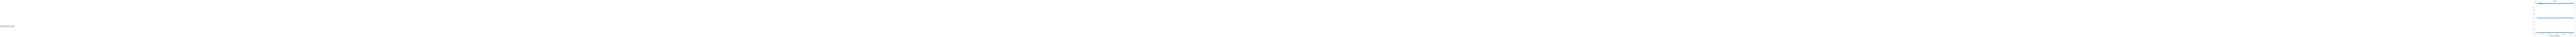

Error in callback <function flush_figures at 0x112d114d0> (for post_execute):


KeyboardInterrupt: 

In [80]:
#dts=np.linspace(0.1,20,32)
dts=np.logspace(-1,2.5,20)
time=1000 #variable for how long the simulation will run for 

AnglesLF_2 = []
AnglesE_2 = []

for i in range(len(dts)): 
    #if dts[i]<...:
    #else...
    Nsteps=time/dts[i]
    Nsteps=int(np.round(Nsteps))
    #print(Nsteps)
    xpos,ypos,xvel,yvel,xacc,yacc=leapfrog(xi,ymax,vi,Nsteps,3,dts[i])
    #xpos_e,ypos_e,xvel_e,yvel_e,xacc_e,yacc_e=euler(xi,ymax,vi,Nsteps,3,dts[i])
    #print(ypos[0][0])
    cut = int(Nsteps/2)
    
    
    coef, poly1d_fn, angle = fit(xpos[0][-cut:],ypos[0][-cut:])
    #coefE,poly1d_fnE,angleE= fit(xpos_e[0][-cut:],ypos_e[0][-cut:])
    AnglesLF.append(angle)
    #AnglesE.append(angleE)
    
    fig, ax = plt.subplots(figsize=[10,8])
    ax.scatter(xpos,ypos,s=25,label='Leapfrog')
    #ax.scatter(0,1.46e11, s=80, label="Large Mass")
    ax.plot(xpos[0][-cut:], poly1d_fn(xpos[0][-cut:]), '--k',lw=4)
    
    #ax.scatter(xpos_e,ypos_e,s=25,label='Euler')
    #ax.plot(xpos_e[0][-cut:], poly1d_fnE(xpos_e[0][-cut:]), '--k',lw=4)
    
    ax.legend(fontsize=13)
    ax.set_title('$\Delta$t: {:d}'.
             format(int(np.round(dts[i]))),fontsize=16)
    ax.set_xlabel('Particle X Position',fontsize=16)
    ax.set_ylabel('Particle Y Position',fontsize=16)
    ax.tick_params(which='both', direction='in',width=2)
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    plt.grid(True)
    #plt.text(-0.95e12,1.3e11, '$\Delta$t: {:d}'.
     #        format(int(np.round(angle[i]))),horizontalalignment='center',bbox={'facecolor':'w'},fontsize=14)
    plt.text(-0.75e12,1.4e11, 'Deflection angle: {:g}'.
             format(angle),horizontalalignment='center',bbox={'facecolor':'w'},fontsize=14)
    
    #print(dt,slope, intercept, Angle:',int(np.round(dts[i])),coef, angle)
    

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned


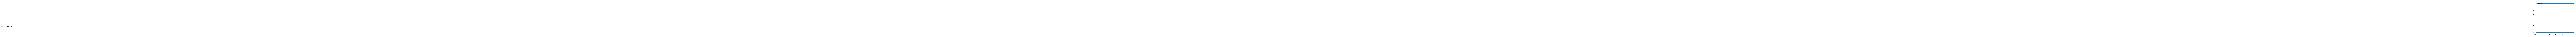

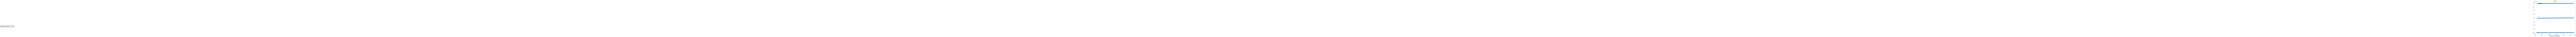

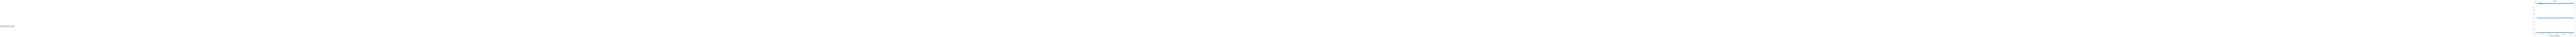

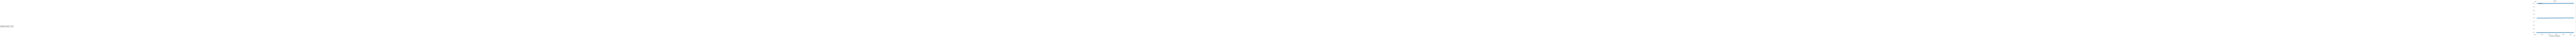

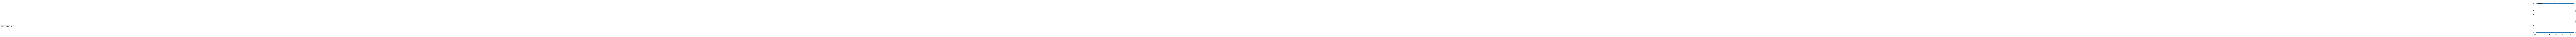

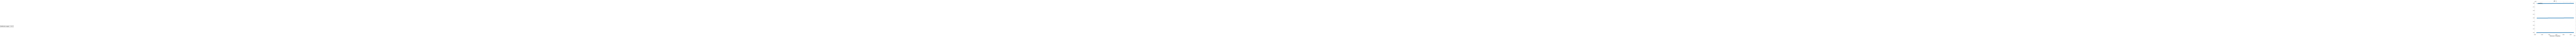

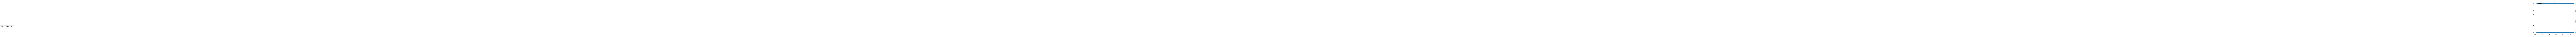

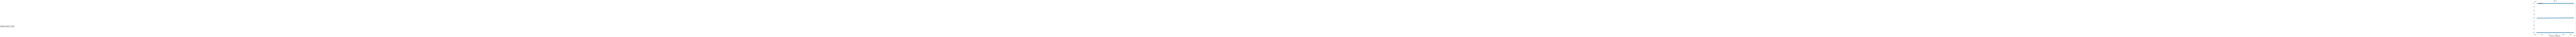

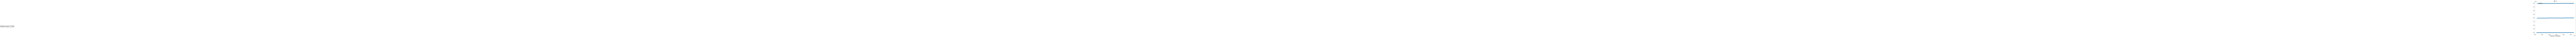

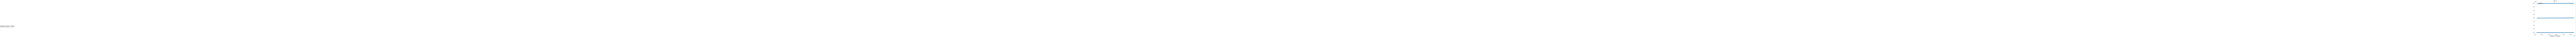

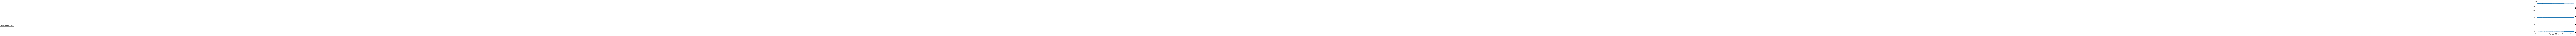

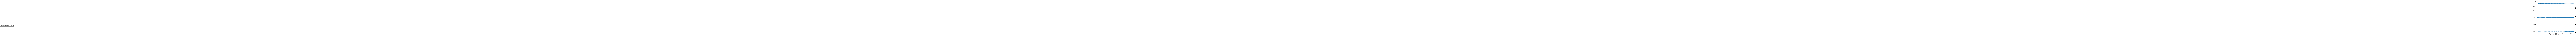

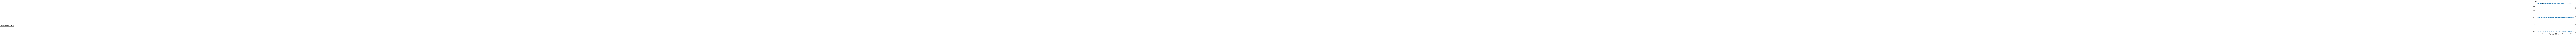

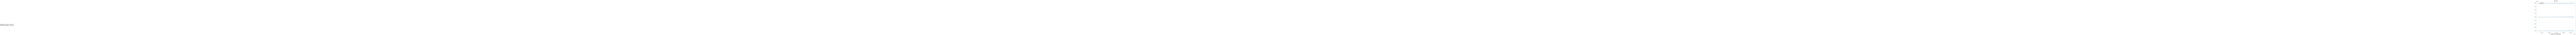

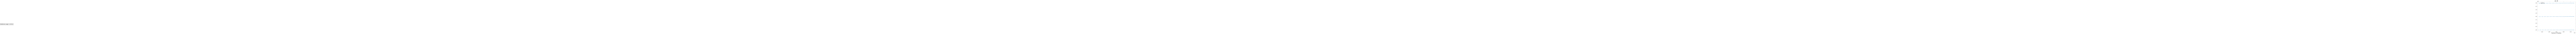

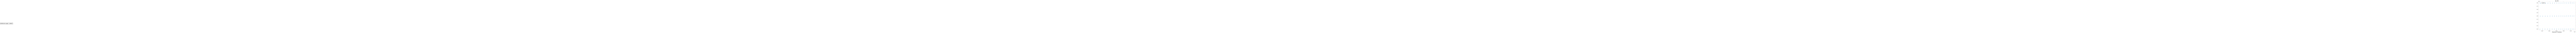

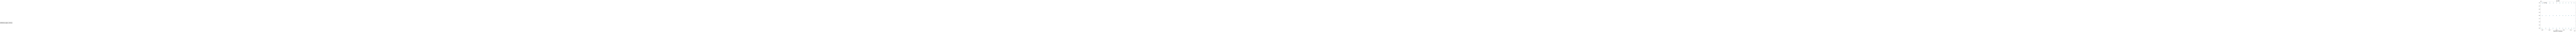

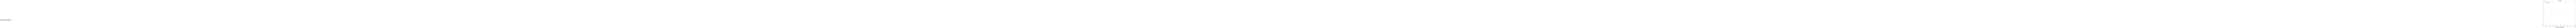

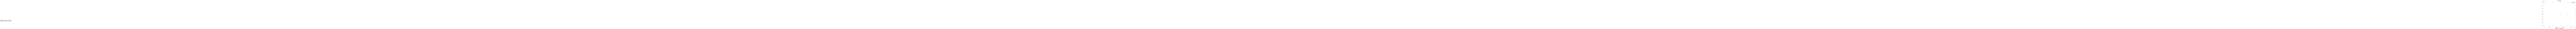

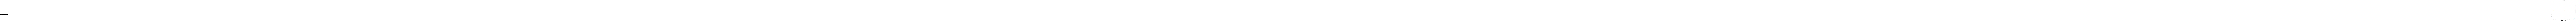

In [79]:
#dts=np.linspace(0.1,20,32)
dts=np.logspace(-1,2.5,20)
time=1000 #variable for how long the simulation will run for 

AnglesLF_2 = []
AnglesE_2 = []

for i in range(len(dts)): 
    #if dts[i]<...:
    #else...
    Nsteps=time/dts[i]
    Nsteps=int(np.round(Nsteps))
    #print(Nsteps)
    xpos,ypos,xvel,yvel,xacc,yacc=leapfrog(xi,ymax,vi,Nsteps,3,dts[i])
    #xpos_e,ypos_e,xvel_e,yvel_e,xacc_e,yacc_e=euler(xi,ymax,vi,Nsteps,3,dts[i])
    #print(ypos[0][0])
    cut = int(Nsteps/2)
    
    
    coef, poly1d_fn, angle = fit(xpos[0][-cut:],ypos[0][-cut:])
    #coefE,poly1d_fnE,angleE= fit(xpos_e[0][-cut:],ypos_e[0][-cut:])
    AnglesLF.append(angle)
    #AnglesE.append(angleE)
    
    fig, ax = plt.subplots(figsize=[10,8])
    ax.scatter(xpos,ypos,s=25,label='Leapfrog')
    #ax.scatter(0,1.46e11, s=80, label="Large Mass")
    ax.plot(xpos[0][-cut:], poly1d_fn(xpos[0][-cut:]), '--k',lw=4)
    
    #ax.scatter(xpos_e,ypos_e,s=25,label='Euler')
    #ax.plot(xpos_e[0][-cut:], poly1d_fnE(xpos_e[0][-cut:]), '--k',lw=4)
    
    ax.legend(fontsize=13)
    ax.set_title('$\Delta$t: {:d}'.
             format(int(np.round(dts[i]))),fontsize=16)
    ax.set_xlabel('Particle X Position',fontsize=16)
    ax.set_ylabel('Particle Y Position',fontsize=16)
    ax.tick_params(which='both', direction='in',width=2)
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    plt.grid(True)
    #plt.text(-0.95e12,1.3e11, '$\Delta$t: {:d}'.
     #        format(int(np.round(angle[i]))),horizontalalignment='center',bbox={'facecolor':'w'},fontsize=14)
    plt.text(-0.75e12,1.4e11, 'Deflection angle: {:g}'.
             format(angle),horizontalalignment='center',bbox={'facecolor':'w'},fontsize=14)
    
    #print(dt,slope, intercept, Angle:',int(np.round(dts[i])),coef, angle)
    

49865956900.0
49865956900.0
49865956900.0
49865956900.0
49865956900.0
49865956900.0
49865956900.0
49865956900.0
49865956900.0
49865956900.0
49865956900.0
49865956900.0
49865956900.0
49865956900.0
49865956900.0
49865956900.0
49865956900.0
49865956900.0
49865956900.0
49865956900.0
49865956900.0
49865956900.0
49865956900.0
49865956900.0
49865956900.0
49865956900.0
49865956900.0
49865956900.0
49865956900.0
49865956900.0
49865956900.0
49865956900.0
49865956900.0
49865956900.0
49865956900.0
49865956900.0
49865956900.0
49865956900.0
49865956900.0
49865956900.0


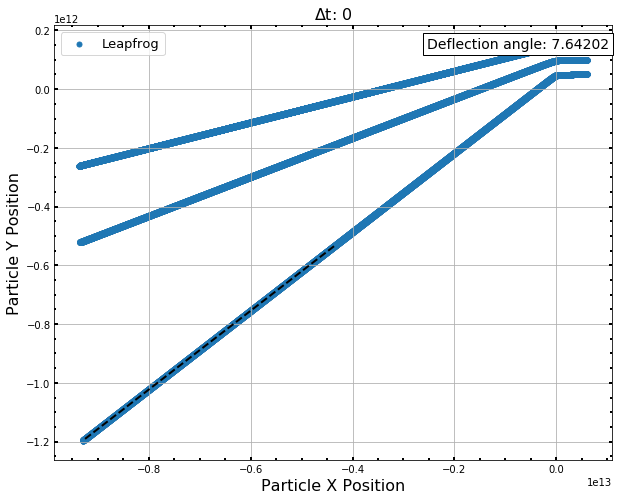

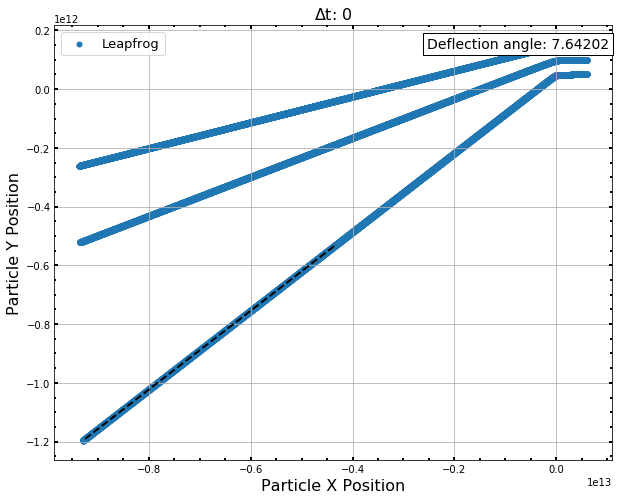

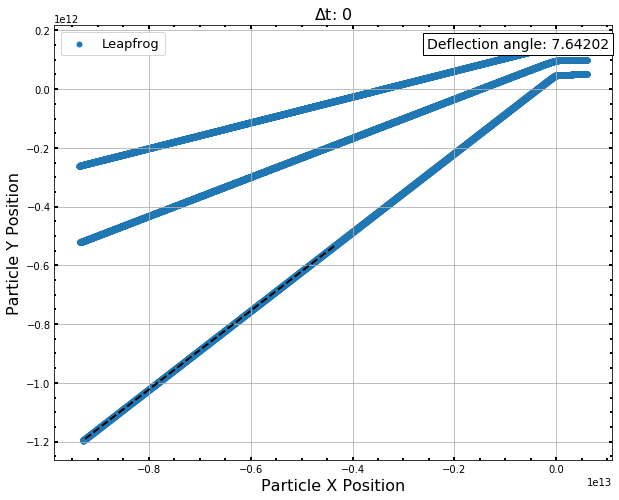

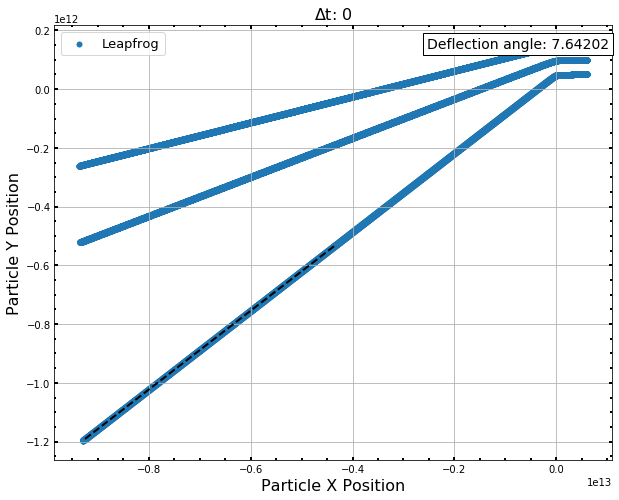

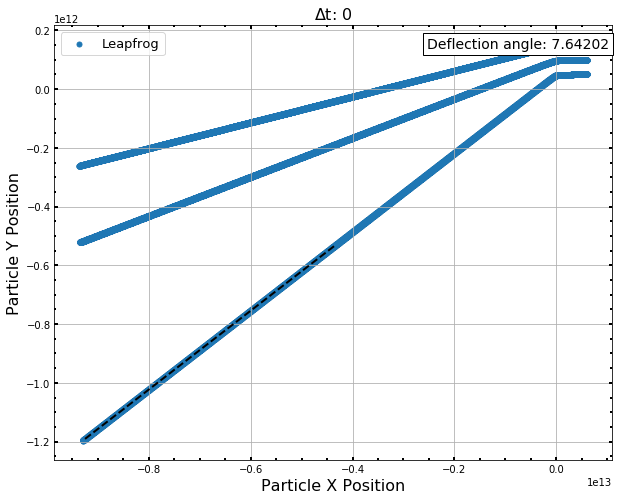

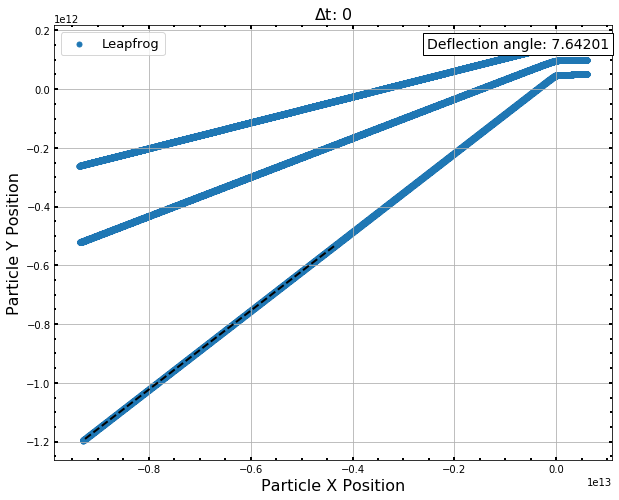

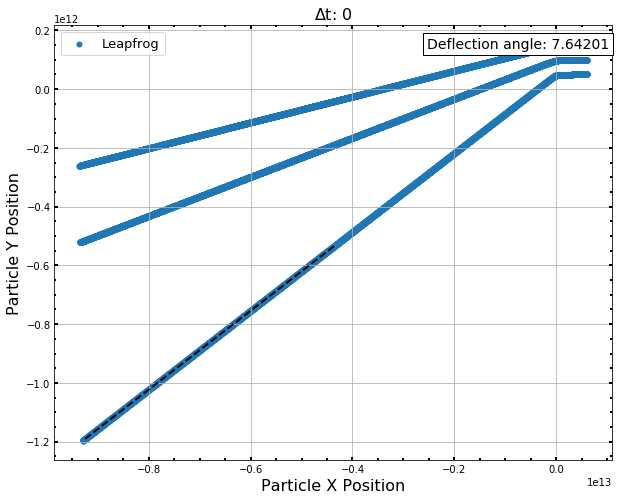

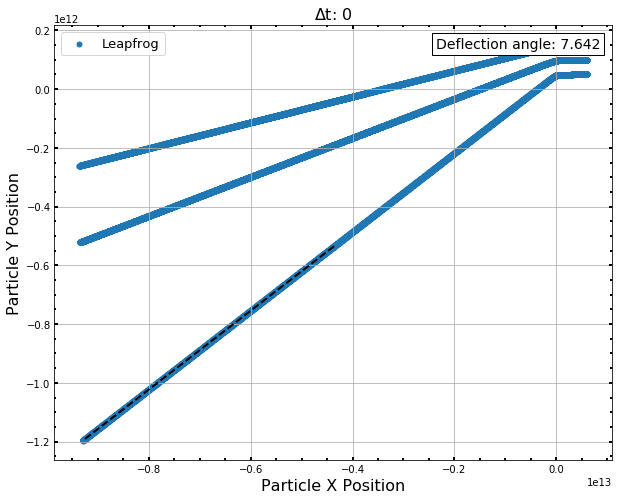

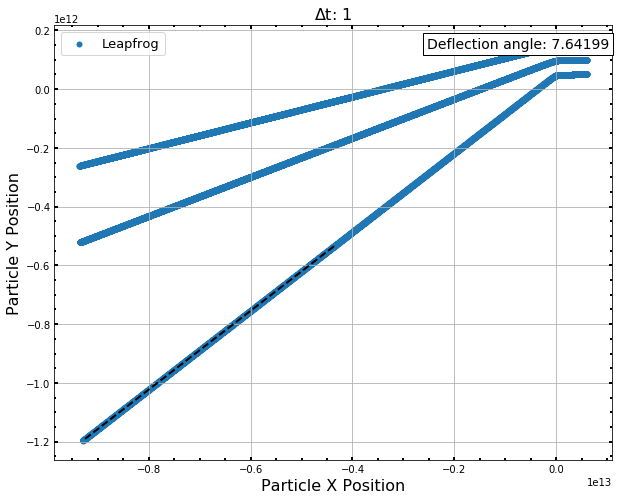

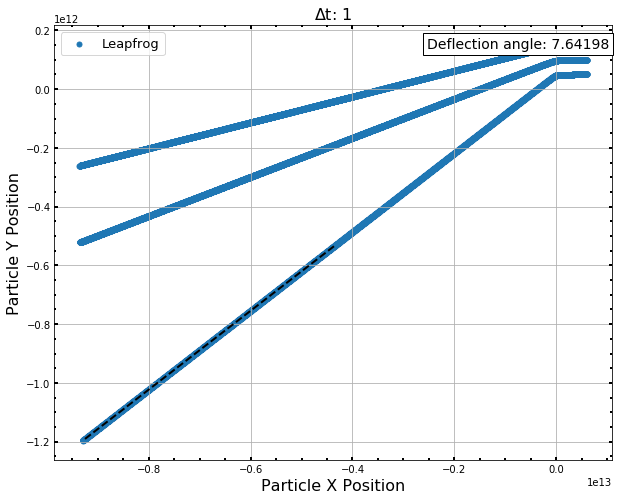

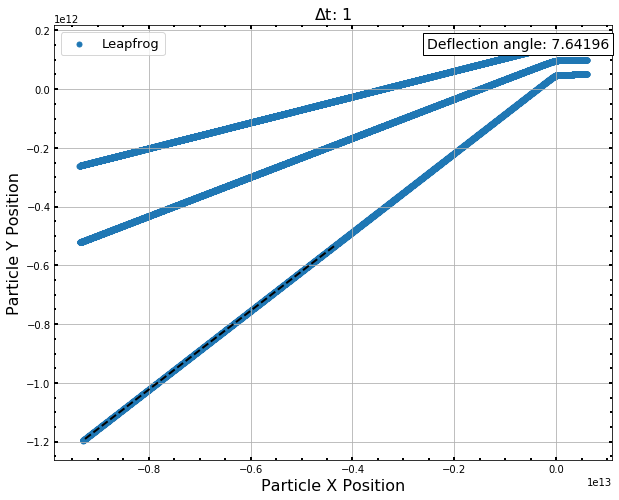

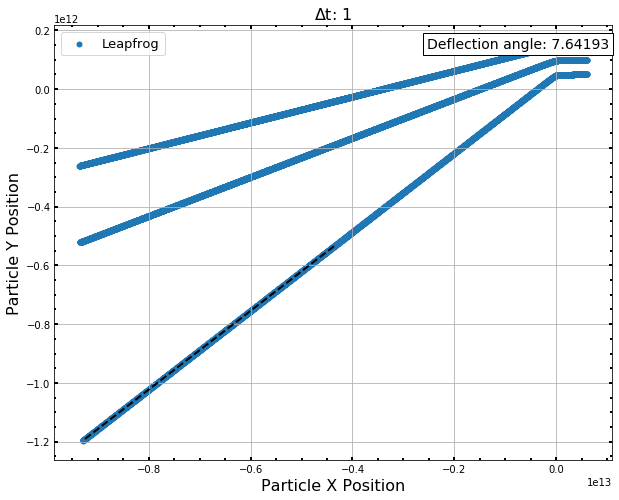

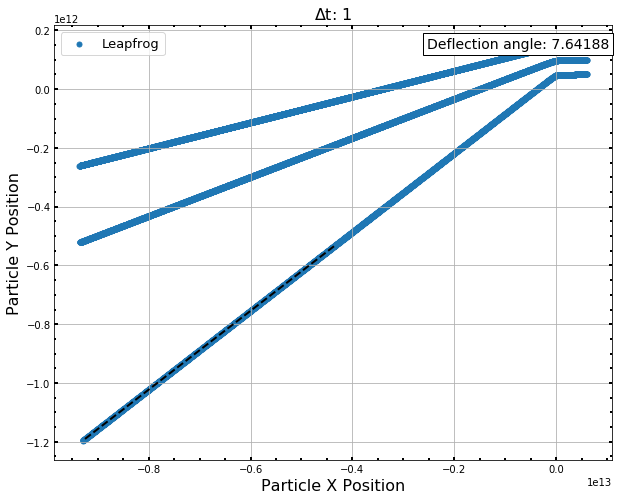

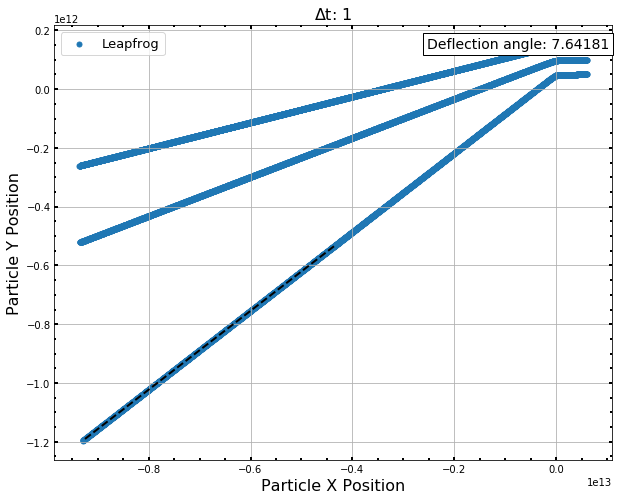

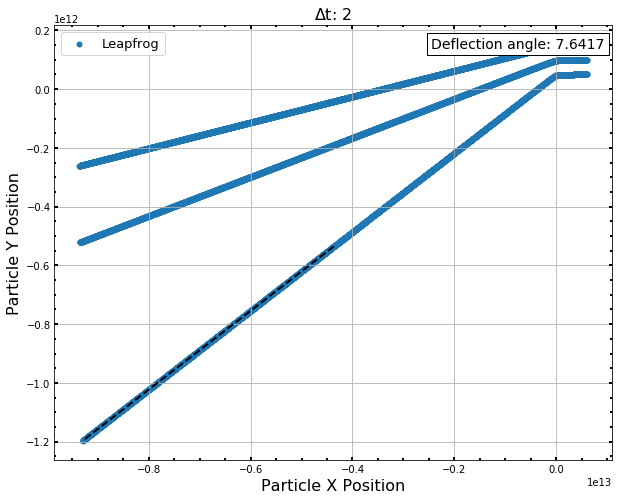

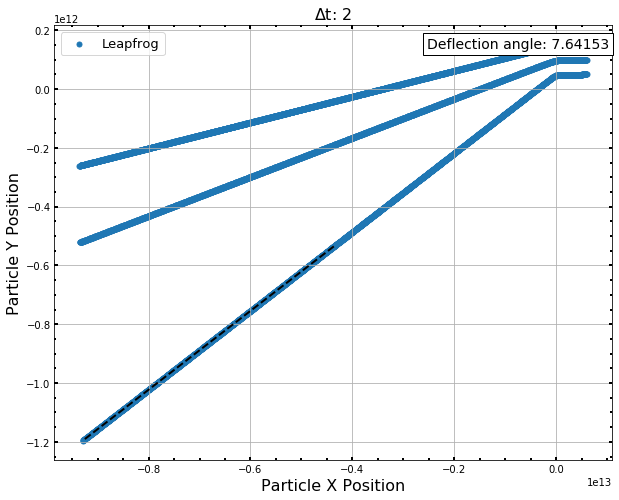

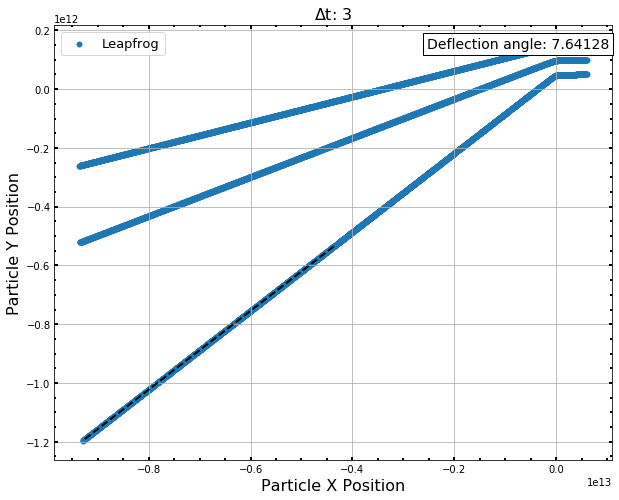

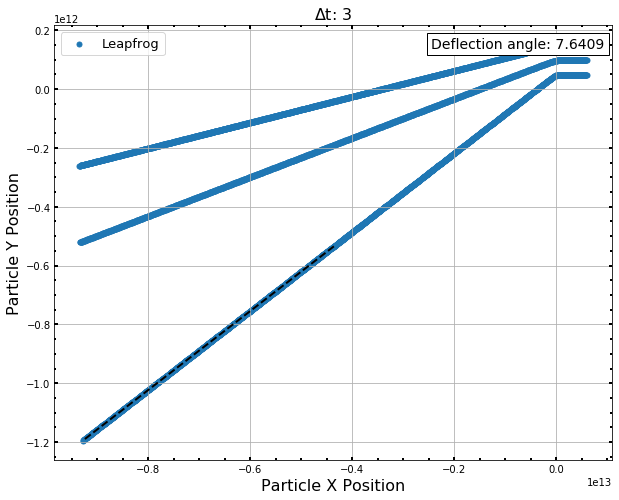

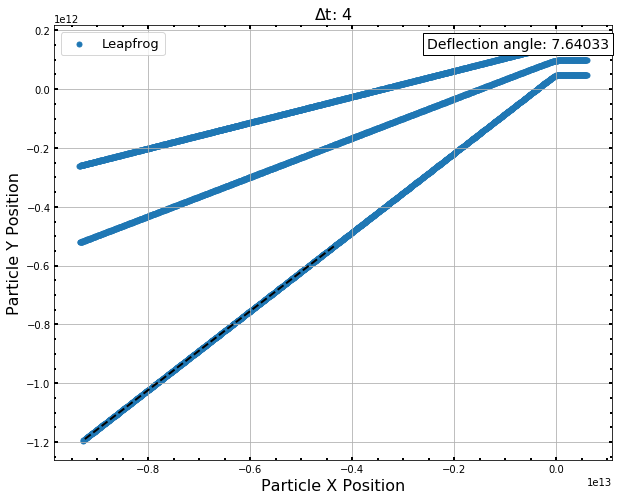

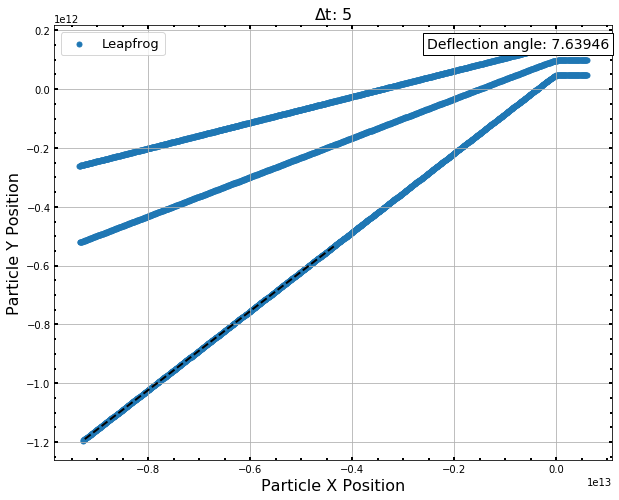

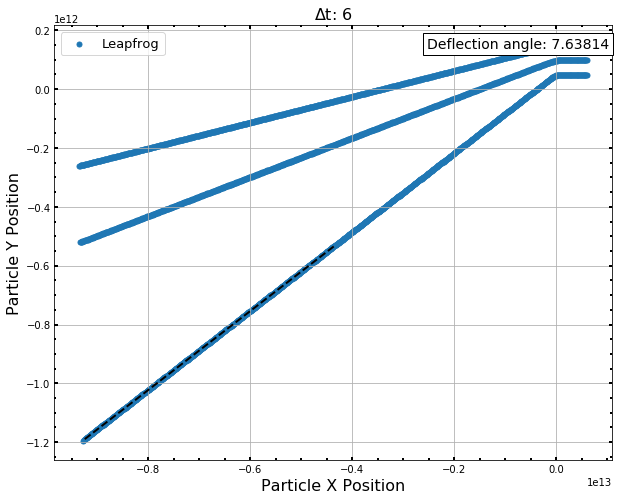

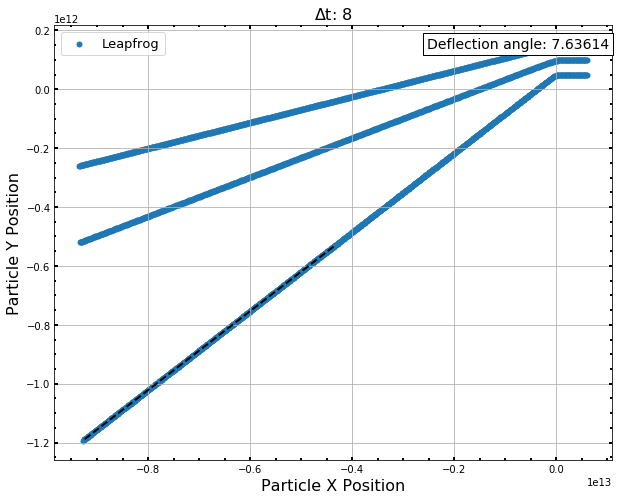

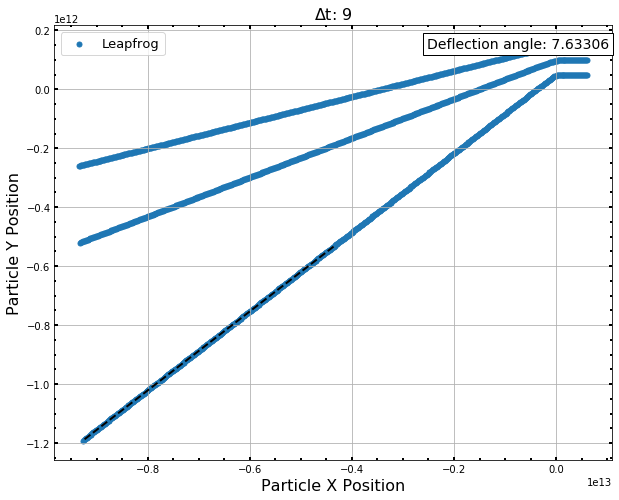

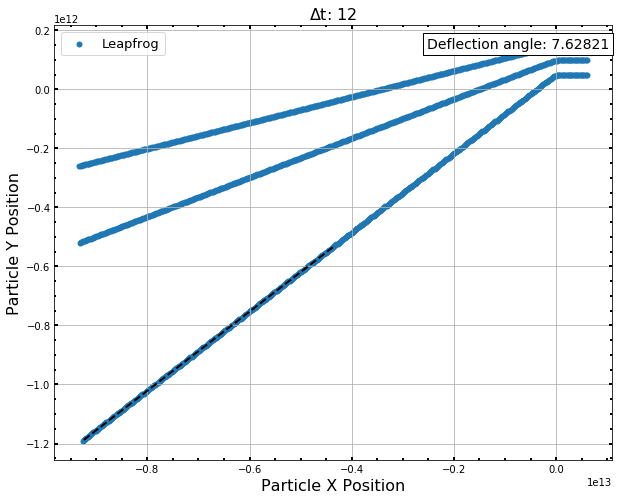

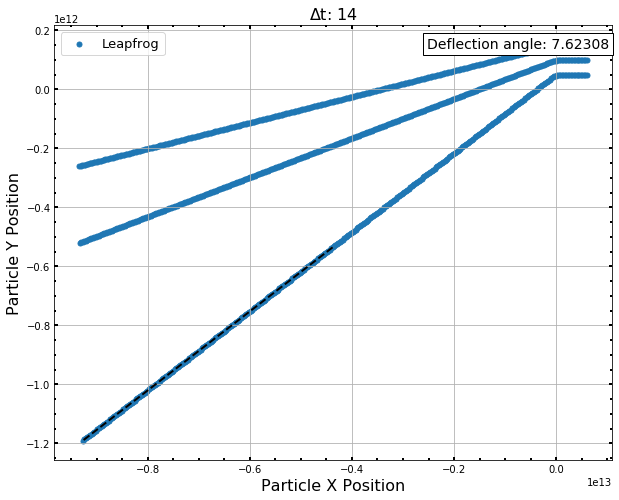

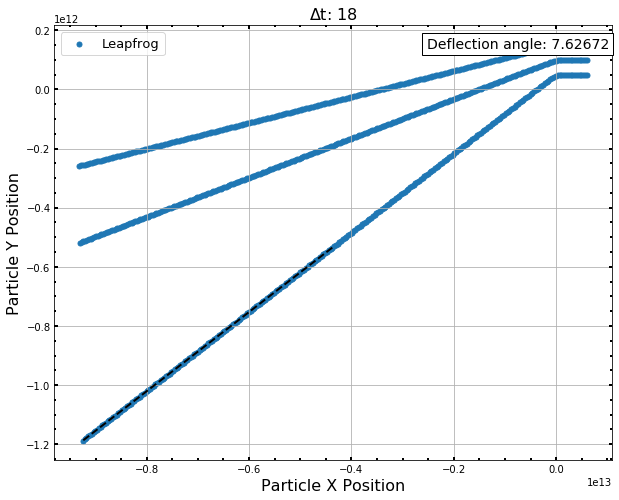

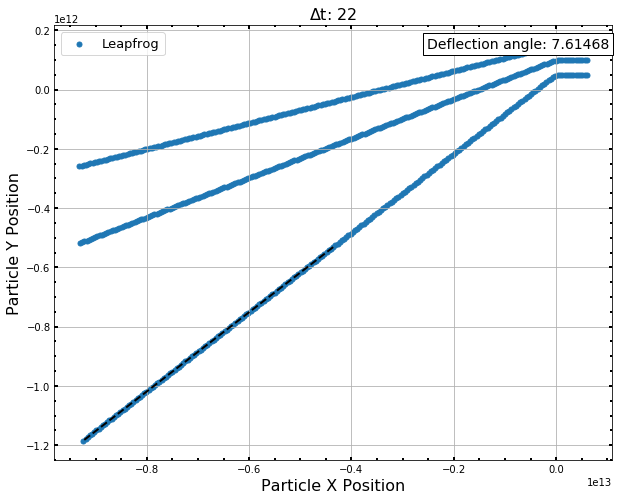

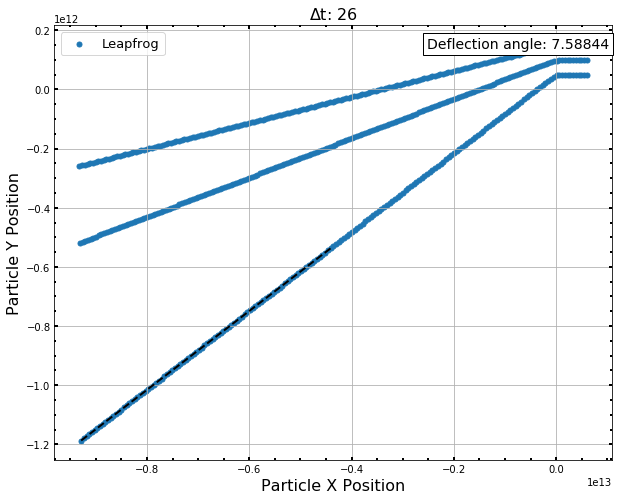

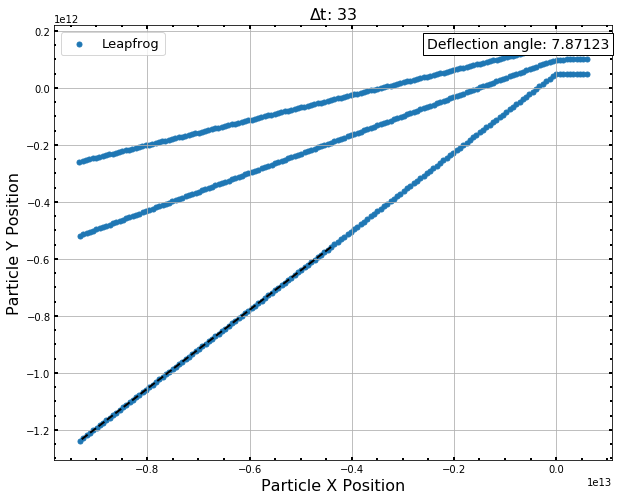

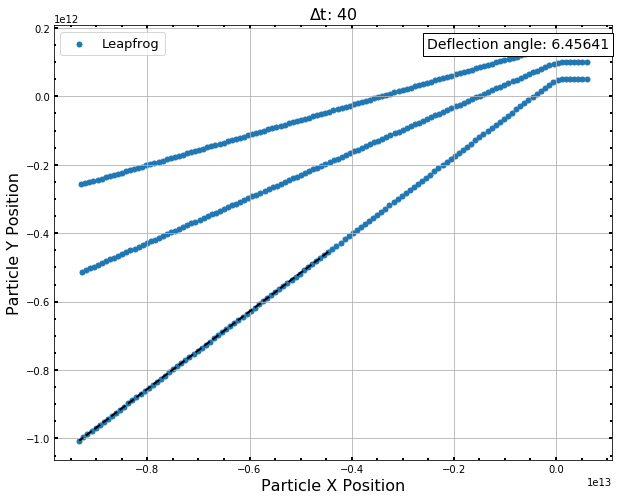

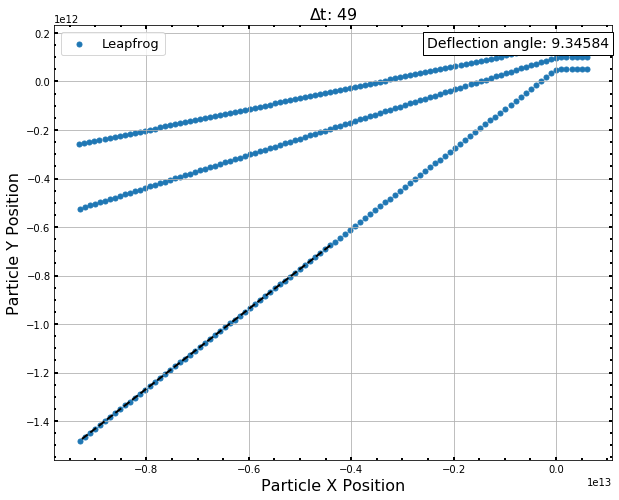

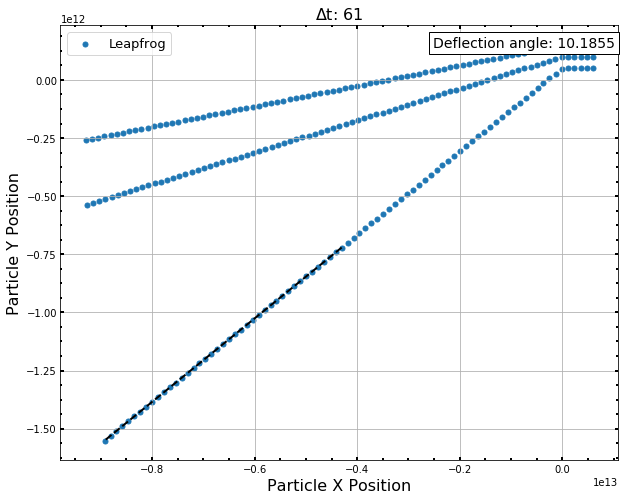

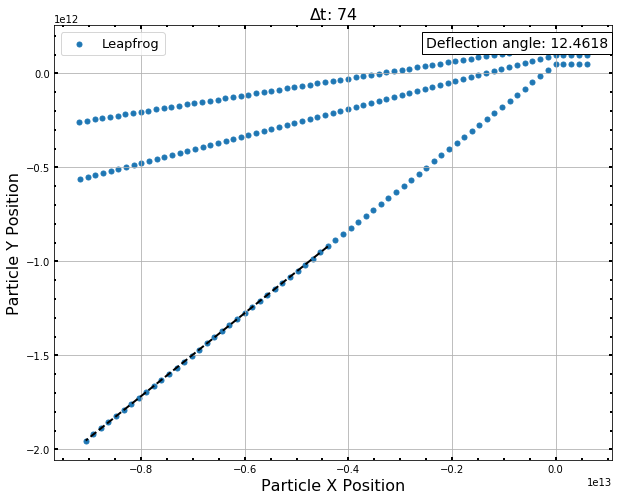

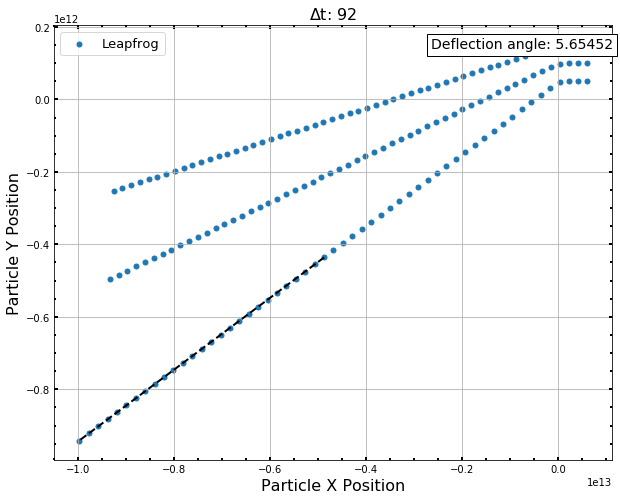

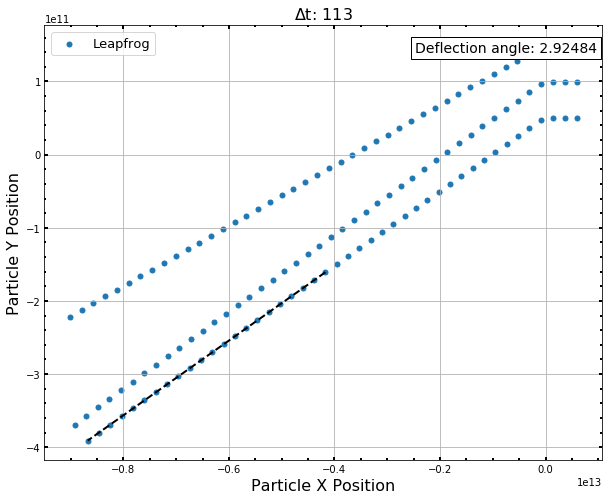

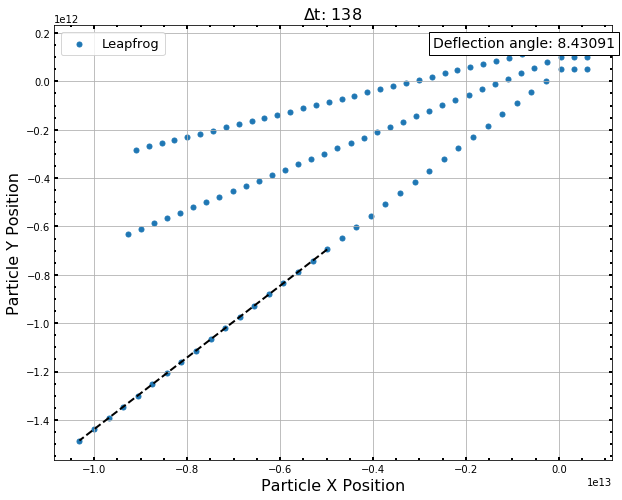

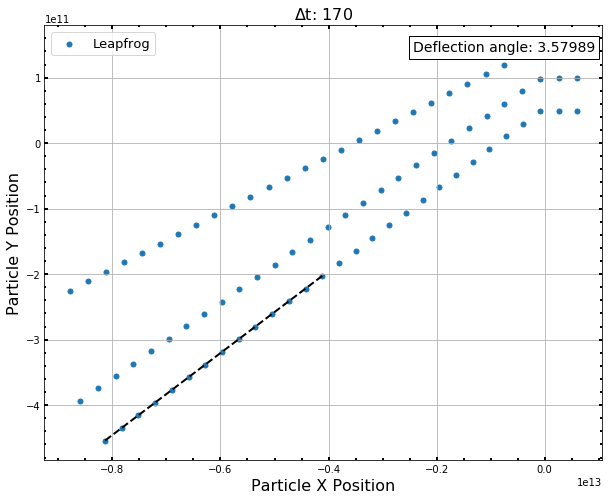

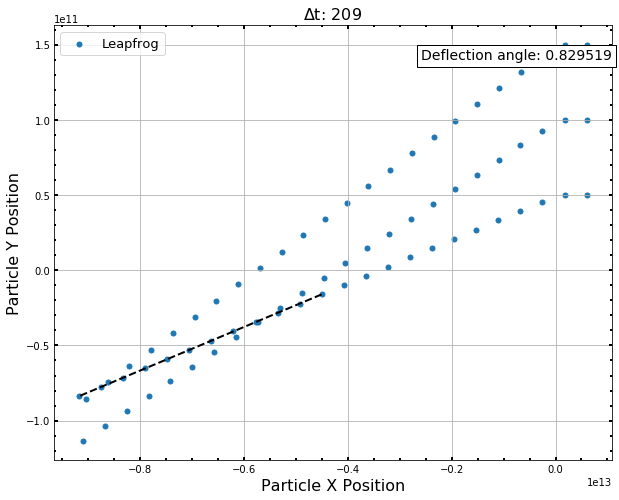

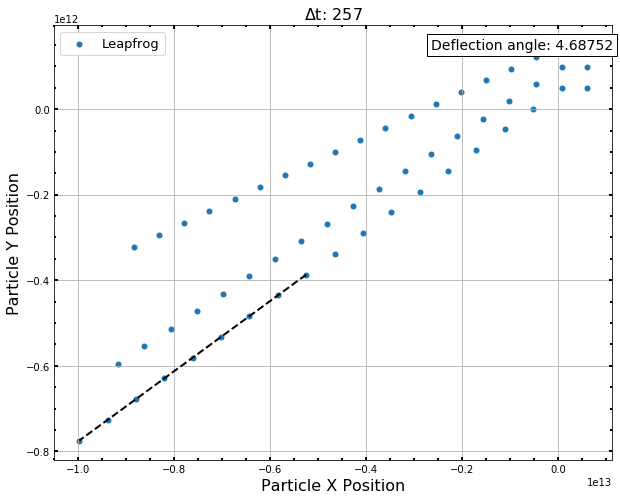

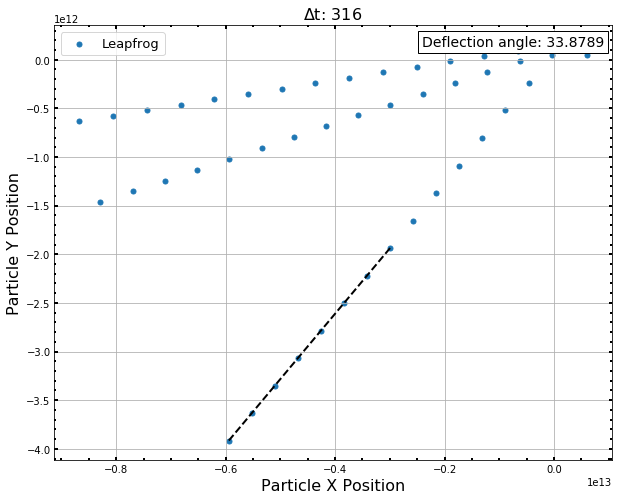

In [297]:
#dts=np.linspace(0.1,20,32)
dts=np.logspace(-1,2.5,40)
time=5000 #variable for how long the simulation will run for 

AnglesLF_2 = []
AnglesE_2 = []

for i in range(len(dts)): 
    #if dts[i]<:
    #else...
    Nsteps=time/dts[i]
    Nsteps=int(np.round(Nsteps))
    xpos,ypos,xvel,yvel,xacc,yacc=leapfrog(xi,ymax,vi,Nsteps,3,dts[i])
    #xpos_e,ypos_e,xvel_e,yvel_e,xacc_e,yacc_e=euler(xi,ymax,vi,Nsteps,2,dts[i])
    print(ypos[0][0])
    cut = int(Nsteps/2)
    
    
    coef, poly1d_fn, angle = fit(xpos[0][-cut:],ypos[0][-cut:])
    #coefE,poly1d_fnE,angleE= fit(xpos_e[0][-cut:],ypos_e[0][-cut:])
    AnglesLF.append(angle)
    #AnglesE.append(angleE)
    
    fig, ax = plt.subplots(figsize=[10,8])
    ax.scatter(xpos,ypos,s=25,label='Leapfrog')
    #ax.scatter(0,1.46e11, s=80, label="Large Mass")
    ax.plot(xpos[0][-cut:], poly1d_fn(xpos[0][-cut:]), '--k',lw=2)
    
    #ax.scatter(xpos_e[0],ypos_e[0],s=25,label='Euler')
    #ax.plot(xpos_e[0][-cut:], poly1d_fnE(xpos_e[0][-cut:]), '--k',lw=2)
    
    ax.legend(fontsize=13)
    ax.set_title('$\Delta$t: {:d}'.
             format(int(np.round(dts[i]))),fontsize=16)
    ax.set_xlabel('Particle X Position',fontsize=16)
    ax.set_ylabel('Particle Y Position',fontsize=16)
    ax.tick_params(which='both', direction='in',width=2)
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    plt.grid(True)
    #plt.text(-0.95e12,1.3e11, '$\Delta$t: {:d}'.
     #        format(int(np.round(angle[i]))),horizontalalignment='center',bbox={'facecolor':'w'},fontsize=14)
    plt.text(-0.75e12,1.4e11, 'Deflection angle: {:g}'.
             format(angle),horizontalalignment='center',bbox={'facecolor':'w'},fontsize=14)
    
    #print(dt,slope, intercept, Angle:',int(np.round(dts[i])),coef, angle)
    

In [295]:
def Psi0(ymax, vi):
    psi0 = ma.atan(((ymax)*vi**2)/(const.G.value*(Big_M+Small_M)))
    return psi0
def theta(psi_0):
    the = ma.degrees(2*psi_0 - np.pi)
    return the

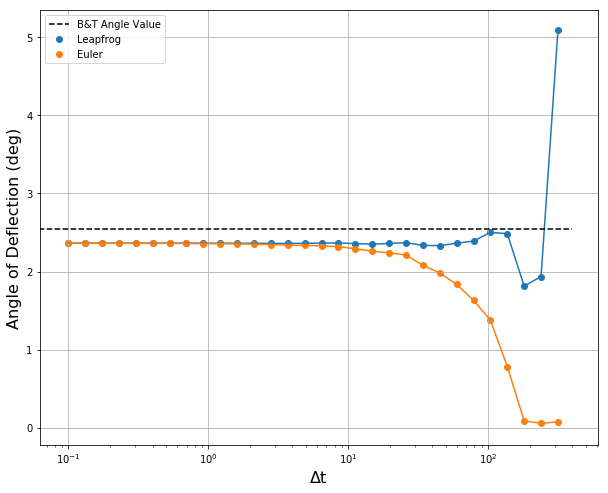

In [201]:
fig, ax = plt.subplots(figsize=[10,8])
ax.scatter(dts,AnglesLF,color='tab:blue',label='Leapfrog')
ax.plot(dts,AnglesLF,color='tab:blue')
ax.scatter(dts,AnglesE,color='tab:orange',label='Euler')
ax.plot(dts,AnglesE,color='tab:orange')
#ax.plot(np.ones(10)*2.5410175957145036,np.linspace(0,6,10),'k--',label='B&T Angle Value')
ax.plot(np.linspace(0,400,100),np.ones(100)*2.5410175957145036,'k--',label='B&T Angle Value')
ax.set_xscale('log')
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)
ax.legend()
ax.set_xlabel('$\Delta$t',fontsize=28)
ax.set_ylabel('Angle of Deflection (deg)',fontsize=28)
plt.grid(True)

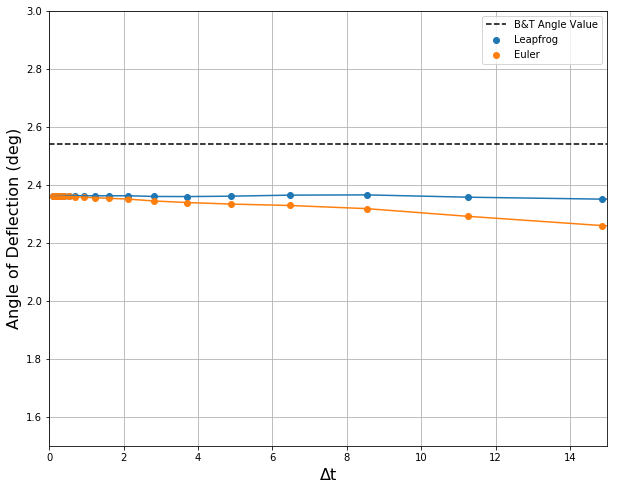

In [195]:
fig, ax = plt.subplots(figsize=[10,8])
ax.scatter(dts,AnglesLF,color='tab:blue',label='Leapfrog')
ax.plot(dts,AnglesLF,color='tab:blue')
ax.scatter(dts,AnglesE,color='tab:orange',label='Euler')
ax.plot(dts,AnglesE,color='tab:orange')
ax.plot(np.linspace(0,200,100),np.ones(100)*2.5410175957145036,'k--',label='B&T Angle Value')
ax.set_ylim(1.5,3)
ax.set_xlim(0,15)
#ax.set_xscale('log')
ax.legend()
ax.set_xlabel('$\Delta$t',fontsize=16)
ax.set_ylabel('Angle of Deflection (deg)',fontsize=16)
plt.grid(True)

In [291]:
theta(Psi0((7.47989354e10),2e9))

-5.079538749095811

In [294]:
theta(Psi0(49865956900.0,vi))

-7.613081715977086